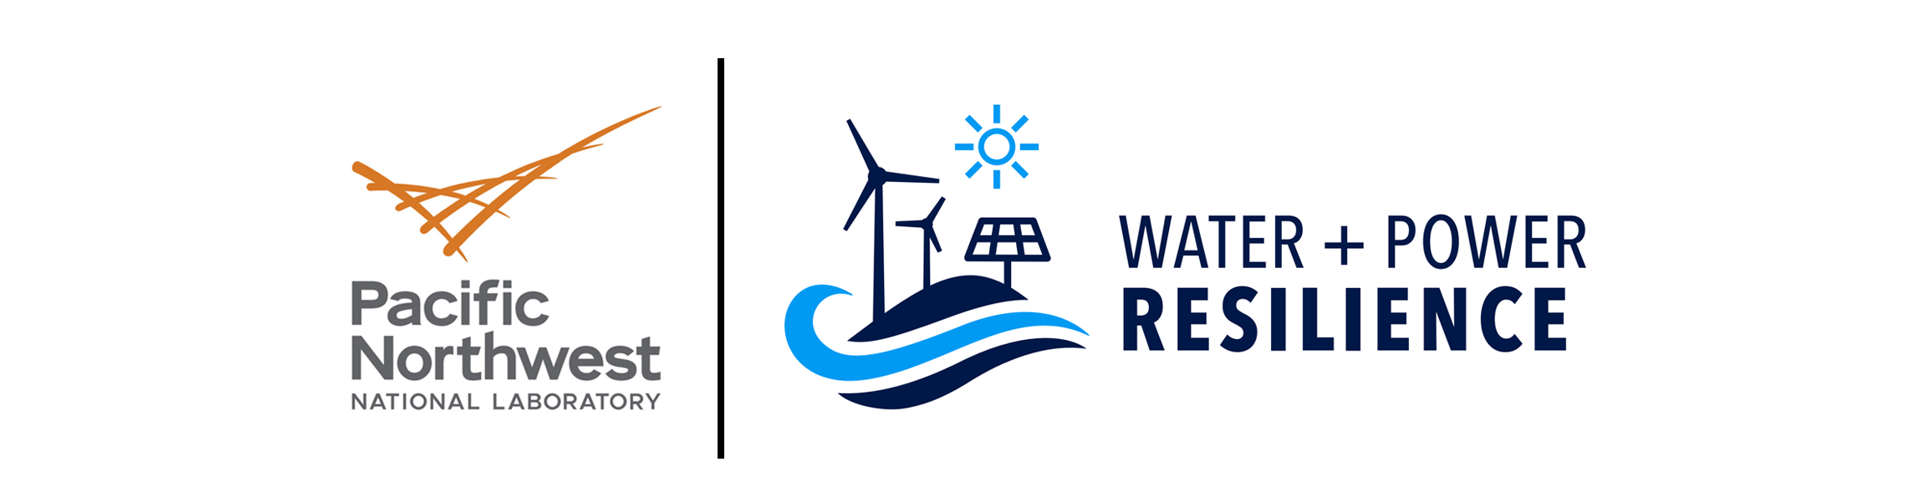

---

# Water & Power Interconnection Sankey Flows (WPISF)
## A Brief Introduction
The dependencies of the water sector on energy and the energy sector on water can lead to multi-faceted and multi-scale vulnerabilities and risks that are further exacerbated in a changing climate. Whether it is threats to water availability for electricity generation or public water supply sources facing the impacts of a power disruption event, the crossovers and interconnections between water and energy are ubiquitous and can have large impacts. While previous research has explored energy-water interconnection visualizations and data at the country-, state-, or even application-level for the U.S., this notebook calculates flows at the U.S. electricity grid interconnection scale. 

The WPISF notebook was created to:

* Reflect the flows between and within the water and energy sectors within the true decision and operational boundaries of the larger electricity sector 
* To provide informed high-level water-energy dependency insights,
* Find similarities and differences between the structure of the three U.S. electricity interconnects, and 
* Identify the relative intensities between the water and energy sectors at the interconnect-level. 

The visualization of the flows and interconnections between water and energy has been done at various scales and levels and in a variety of ways. Sankey diagrams, which provide a proportional representation of processes and major transfers within a system, are one of the most popular visualization methods for this research area. Looking from a high-level perspective, very few diagrams are available that represent the water and energy sectors equally with most diagrams choosing one sector or the other to focus on. The figure below outlines the structure of flows and dependencies across and within the water and energy sectors that are calculated within the notebook.

![image](https://user-images.githubusercontent.com/74064300/135877886-91cac5ec-614a-4fee-b9d2-3561bb69d62c.png)

The notebook below walks through the calculations required to obtain flow values for both the water and energy sectors at the interconnect-level. The final output includes an excel file of flows (in million gallons per year (MGY) for water flows and billion british thermal units (BBTU) for energy). This data can be used in the production of water-energy sankey diagrams as well for separate analysis.

## Additional Information:
* Calculations are for the year 2015, the most recent year available for US water data from USGS
* Calculation methodologies and assumptions, when informed by the literature, will point to references included at the end of this notebook.
* Water values are ultimately provided in million gallons per year (MGY) and energy values are provided in billion british thermal units (BBTU)
* Data was available at various levels of granularity. When data is provided at county-level, it is mapped to information on which interconnect that county belongs to. When data is provided at the state-level, state-level totals are divided among state counties through an appropriate method (e.g. population). When information is available at the plant level, various methods were applied to aggregate to the interconnect-level and are described in more detail in the relevant sections of the notebook.
* Some data is available and collected where possible for areas outside of the three interconnections (including Alaska, Hawaii, and U.S. Territories). This information, however, is exluded from the final dataset.

---

<h2> Imports

In [1]:
import pandas as pd
import numpy as np

import flow


<h1> 2015 USGS Water Data
<a id="Water-Supply"></a>

The majority of water use estimates are from the 2015 USGS report documenting water use in the US, which provide water values at the county-level for a number of variables [1]. To aggregate to the interconnection-level, the county-level USGS values are mapped to a county-interconnect crosswalk. The county to interconnect crosswalk for 2015 was informed by [2] and [3]. Note that in reality, multiple interconnects may operate in one county. The mapping used in this notebook is an approximation of interconnnect boundaries.

In [5]:
df = flow.get_water_use_2015()

/Users/d3y010/.pyenv/versions/py3.9.4_flow/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [8]:
df.columns.shape

(141,)

In [2]:
interconnect = flow.get_interconnect_data()


In [3]:
interconnect.fips

,FIPS,Interconnect
0,02013,None
1,02016,None
2,02050,None
3,02060,None
4,02110,None
...,...,...
3218,56037,West
3219,56039,West
3220,56041,West
3221,56043,West


The 2015 USGS water data is merged with the interconnect by county file to link the 2015 water data to each interconnect.
This gives us a dataframe of a number of water values for 2015 at the county level.

In [3]:
df = flow.prep_water_2015(interconnect)


/Users/d3y010/.pyenv/versions/py3.9.4_flow/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


# 1995 USGS Water Data
The 2015 USGS water dataset does not provide values for all water flows. Missing flows include public water supply to sectors other than residential end-users or thermoelectric cooling, consumptive use of water for nearly all sectors, and water use in hydroelectric generation. The most recent estimates for these values are found in the 1995 USGS water report [4]. To obtain 2015 values for these missing variables, coefficients and intensity rates are calculated from the 1995 dataset and applied to the 2015 water data.

 <h2>Water Consumption Fraction Calculations

Consumption fractions (CF) are the percent of total water delivered that is consumed or evaporated. As mentioned, this value is not included in the 2015 USGS water report [1] and must be calculated from the most recently available data [4]. This process follows the same methodology for consumptive use found in [5].
<br> Note:
* For residential end-users, domestic water consumption (DO_CF) is equal to the ratio of total domestic water consumed (DO-CUTot) to total domestic water delivered (DO-WDelv)
* For industrial end users and mining, different consumption values exist for saline and fresh water. Each of these consumption intensities are calculated separately.
* Water in agriculture consists of water withdrawals for irrigation, livestock, and aquaculture. Each of these subsectors have different consumption rates and are separately calculated here, though all three are ultimately aggregated into a single agriculture sankey node.
* For simplification, industrial, commercial, and mining are ultimately combined into a single end-use category. However, given that their consumptive use patterns are different, they are calculated separately and ultimately combined.

### Calculate 1995 consumption fractions to apply to 2015 USGS water values

<div class="alert alert-block alert-success">
<b>See the code behind this function:</b> www.google.com
</div>

In [4]:
df_1995 = flow.prep_water_1995()


Some counties have values of 0 MGD for the various sectors above. These instances are adjusted below.

## Hydroelectric Generation Water Intensity Calculations
The amount of water (MGY) use per gigawatt-hour (GWh) of electricity produced can be calculated from the 1995 USGS data for conventional hydro. No recent national data is available on water used in hydroelectric generation.
In 1995, the total estimated amount of water use in the US for hydroelectric generation was over 3.1 million MGD (1,153 million MGY) [4].

To calculate water use in hydroelectric generation (HY_Intensity), the water in on-stream conventional hydropower (HY-InUse) is divided by the GWh of hydroelectric generation (HY-InPow) by county from [4]. Intensity values are averaged by state and later applied to individual power plant generation values for 2015.

A number of states have large values for hydropower water intensity that are presumed to be outliers. As a result, intensity values are capped at 60,000 MGY/MWh prior to taking the average for the each state.

In [205]:
#copying 1995 dataframe hydropower columns
Hydro_df_red = df_1995[["State","HY-InUse","HY-InPow"]].copy()

#Total amount of water use in conventional hydro generation (MGD) divided by the total power generated (GWH)
#and converts it to MGY/GWh
Hydro_df_red["HY_Intensity"] = (((Hydro_df_red["HY-InUse"])/(Hydro_df_red["HY-InPow"]))*365)

#removing presumed outliers
Hydro_df_red = Hydro_df_red[Hydro_df_red.HY_Intensity <= 60000]

#aggregate average U.S. intensity (MGY/GWh)
HY_Intensity_USavg = Hydro_df_red["HY_Intensity"].mean()

Hydro_df_red = Hydro_df_red.groupby("State", as_index=False).mean()         #group by state
Hydro_df_red = Hydro_df_red[["State","HY_Intensity"]]                       #reduce variables

In [206]:
Hydro_df = df_1995[["State","HY-InUse","HY-InPow"]].copy()                  #copy 1995 dataset
Hydro_df = Hydro_df.groupby("State", as_index=False).sum()                  #group by state to get original state list
Hydro_df = pd.merge(Hydro_df, Hydro_df_red, on="State", how="left")         #merge with intensity df

Hydro_df["HY_Intensity"].fillna(HY_Intensity_USavg, inplace=True)           #replace blank states with national avg.

#rename column name
Hydro_df = Hydro_df.rename(columns={"State": "STATE"})

## Simplifying 1995 water dataframe and merging with 2015 water dataframe

The code below reduces the 1995 dataset to just include the newly calculated consumption fractions. These fractions, available at the county-level, allow us to calculate out the missing flow values from the 2015 dataset [1] with the 1995 intensities [4].

In [207]:
#Keeping only variables of interest in the 1995 dataset
df_1995 = df_1995[["State","CountyName","FIPS","DO_CF",
                   "INCO_CF_Fr", "INCO_CF_Sa", "MI_CF", 
                   "MI_CF_Fr", "MI_CF_Sa", "LV_CF",
                   "LA_CF", "IR_CF"]].copy()

Before the 1995 consumption fractions can be merged to the 2015 data, various county codes must be adjusted. A select number of counties exist in the 2015 USGS dataset that do not exist in the 1995 USGS dataset that must be accounted for. These include:
* Dade County, FL (FIPS 12025) changed to Miami-Dade County, FL (FIPS 12086)
* Broomfield County, CO (FIPS 08014) is a new county formed in 2001, split from Boulder County, CO (FIPS 08013)
* Shannon County, SD (FIPS 46113) changed to Oglala Lakota County, SD (FIPS 46102)
* Skagway-Hoonah-Angoon Cen (FIPS 02232) changed to Hoonah-Angoon Census Area, AK (FIPS 02105)
* Wade Hampton Census Area (FIPS 02270) changed to Kusilvak Census Area, AK (FIPS 02158)
* Wrangell-Petersburg Censu (FIPS 02280) changed to Petersburg Borough, AK (FIPS 02195)
* Pr. of Wales-Outer Ketchi (FIPS 02201) changed to Prince of Wales-Hyder Census Area, AK (FIPS 02198)
* Skagway-Hoonah-Angoon Cen (FIPS 02232) changed to Skagway Municipality, AK (FIPS 02230)
* Wrangell-Petersburg Censu (FIPS 02280) changed to City & Borough of Wrangell, AK (FIPS 02275)
* St. Croix County, VI (FIPS 78001) changed to St. Croix County, VI (FIPS 78010)
* St. John County, VI (FIPS 78003) changed to St. John County, VI (FIPS 78020)
* St. Thomas County, VI (FIPS 78004) changed to St. Thomas County, VI (FIPS 78030)

These are each adjusted below to match 1995 to 2015 data appropriately. Note that a majority of these corrections are made for areas that are not ultimately included in the interconnect-level dataset as they exist outside of the three interconnects.

In [208]:
#county-splits

#Hoonah-Angoon Census Area, AK
df_02280 = df_1995[df_1995.FIPS == "02280"].copy()
df_02280['FIPS'] = np.where(df_02280['FIPS'] == "02280","02275", df_02280['FIPS'])

#Hoonah-Angoon Census Area, AK
df_02232 = df_1995[df_1995.FIPS == "02232"].copy()
df_02232['FIPS'] = np.where(df_02232['FIPS'] == "02232","02230", df_02232['FIPS'])

#colorado
df_08013 = df_1995[df_1995.FIPS == "08013"].copy()
df_08013['FIPS'] = np.where(df_08013['FIPS'] == "08013","08014", df_08013['FIPS'])

frames = [df_02280, df_02232, df_08013]
result = pd.concat(frames)

#FIPS code changes
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "12025","12086", df_1995['FIPS'])
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "46113","46102", df_1995['FIPS'])
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "02232","02105", df_1995['FIPS'])
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "02270","02158", df_1995['FIPS'])
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "02280","02195", df_1995['FIPS'])
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "02201","02198", df_1995['FIPS'])
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "78001","78010", df_1995['FIPS'])
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "78003","78020", df_1995['FIPS'])
df_1995['FIPS'] = np.where(df_1995['FIPS'] == "78004","78030", df_1995['FIPS'])

frames_2 = [result, df_1995]
df_1995 = pd.concat(frames_2)

#bring 1995 calculated fractions into 2015 dataset
df = pd.merge(df, df_1995, how= "left")

***

<h1>2015 Water Withdrawals, Deliveries, Consumption, and Discharge Calculations

<h2> Public Water Supply

### Public Water Supply to Residential
Accounts for all water flows from the public water supply system to redisential end-uers. No calculation is required for this variable, it is provided directly from the 2015 USGS dataset under code DO-PSdel [1].

### Public Water Supply to Thermoelectric Cooling
Includes all water flows from the public water supply system to thermoelectric power plants by county. No calculation is required for this simplified thermoelectric cooling value. Code PT-PSdel can be used from the 2015 USGS water dataset [1] to get a total approximation for all generation and cooling types in total. <br>
<b> Note: </b>For thermoelectric cooling estimates in this analysis, more detailed thermoelectric cooling data is available and calculated seperately in the Thermoelectric Cooling notebook. The values are based on USGS thermoelectric cooling water data for 2015 [6]. The process to bring in the detailed thermoelectric cooling water use data is included in the appendix of this notebook.

<h3> Public Water Supply to Industrial & Commercial End Users (INCO_PSDel) </h3>

There is no 2015 data on public water supply deliveries to industrial or commercial customers. The 2015 USGS water dataset [1] includes public water supply deliveries to residential end-users, thermeoelectric cooling, and total water withdrawals for public water supply in a county. It is assumed, therefore, that the difference between the total public water supply and the sum of deliveries to residential and thermoelectric cooling can be used as an approximation for deliveries to industrial and commercial end-users combined.

Note that this calculation is done on a county level and in some counties this results in a negative value for industrial and commercial deliveries from public water supply. This occurs if the total public water supply in that county is less than the amount of public water supply consumed by residential end users and thermoelectric cooling in that county. This situation can be interpreted as public water supply imports from other counties.

There is no 2015 data on total public water supply delivered to a county, only the "production" of it (i.e. withdrawals) in that county, making it difficult to correct for negatives values on the county level. The assumption used here, however, is that when counties are aggregated to the interconnect level, imports and exports across counties will be balanced.

Note that the negative values mentioned above track through to calculations for water deliveries to wastewater treatment  based on dependencies. Therefore, some wastewater treatment values at the county level are negative as well.

In [209]:
#public water supply to industrial, commercial, & mining in aggregate.
df["INCO_PSDel"] = df["PS-Wtotl"] - df["DO-PSDel"] - df['PT-PSDel']

## Water Withdrawals (Self-Supply)

In addition to public water supply, end-users can also withdraw their own self-supply of water. Commercial end-users are the only end-users that do not withdraw their own water, according to the 2015 USGS data [1].

<h3> Water Withdrawals by Residential Sector (Self-Supply) </h3> <br>
No calculation required. Used directly from 2015 USGS dataset [1] under codes DO-WGWFr, DO-WSWFr, DO-WGWSa, DO-WSWSa.

<h3> Water Withdrawals by Industrial, Commercial, & Mining (Self-supply) </h3> <br>
Industrial, commercial, and mining end users are considered in aggregate in this analysis. Commercial end users do not have any self-supply withdrawals. Therefore, the self-supply withdrawals for the industrial and mining sectors are added together (Industrial, Commercial, & Mining = INCOM). These values are provided directly from the 2015 USGS dataset [1] under codes: IN-WGWFr, IN-WSWFr, IN-WGWSa,IN-WSWSa, MI-WGWFr, MI-WSWFr, MI-WGWSa, and MI-WSWSa.

In [210]:
#industrial + mining self-supply

df["INCOM-WGWFr"] = df['IN-WGWFr'] + df['MI-WGWFr']                  #fresh groundwater to industrial & mining
df["INCOM-WSWFr"] = df['IN-WSWFr'] + df["MI-WSWFr"]                  #fresh surface water to industrial & mining
df["INCOM-WGWSa"] = df['IN-WGWSa'] + df["MI-WGWSa"]                  #saline groundwater to industrial & mining
df["INCOM-WSWSa"] = df['IN-WSWSa'] + df["MI-WSWSa"]                  #saline groundwater to industrial & mining

<h3> Water Withdrawals by Agriculture Sector (Self-Supply)

Water in agriculture is the sum of water withdrawals for irrigation, livestock, and aquaculture, following the methodology provided in [5]. Only fresh water is delivered to agriculture. These values are provided directly from the 2015 USGS dataset [1] under codes: IR-WGWFr, LI-WGWFr, AQ-WGWFr, IR-WSWFr, LI-WSWFr, and AQ-WSWFr.

In [211]:
#Combining irrigation, livestock, and aquaculture into single agriculture component
df["AG-WGWFr"] = df['IR-WGWFr'] + df['LI-WGWFr'] + df['AQ-WGWFr']      #fresh groundwater to agriculture
df["AG-WSWFr"] = df['IR-WSWFr'] + df['LI-WSWFr'] + df['AQ-WSWFr']      #fresh surface water to agriculture

## Sectoral Use to Consumption/Evaporation
    
Water delivered to end users is either discharged (surface discharge, ocean discharge, or discharge to wastewater treatment) or consumed/evaporated. This section evaluates the portion of all water delivered to end users that is ultimately consumed or evaporated.

As mentioned previously, no 2015 consumptive use (CU) data exists for a majority of the sectors in the 2015 USGS dataset [1]. Consumption fraction assumptions were calculated from the 1995 USGS dataset [4] (see earlier section) and are applied here to 2015 values to fill this data gap. This gives water flows from sectoral use nodes to consumption/evaporation.

Note that for the consumptive use calculation for industrial, commercial, and mining (INCOM_CU) , only self-supplies to industrial and mining are used given that the commercial sector does not have self-supply.

Calculations in this section follow the methodology outlined in [5], however, industrial, commercial, and mining are not aggregated in the report as they are here.

In [212]:
#Residential consumptive use is the consumption fraction multiplied by total water delivered
#total water delivered is the sum of public supply deliveries and self-supply withdrawals
df["DO_CU"] = df["DO_CF"] * (df['DO-PSDel'] + df['DO-WGWFr'] + df['DO-WSWFr'])                   #residential CU


#Industrial & Commercial consumptive use (using total public supply to both and self-supply to industrial)
#fresh and saline water are consumed at different ratios
df["INCO_CUFr"] = df["INCO_CF_Fr"] * (df['INCO_PSDel'] + df["IN-WGWFr"] + df["IN-WSWFr"])        #Ind & Com. CU (fresh)
df["INCO_CUSa"] = df["INCO_CF_Sa"] * (df["IN-WGWSa"] + df["IN-WSWSa"])                           #Ind & Com. CU (saline)
df["INCO_CU"] = df["INCO_CUFr"] + df["INCO_CUSa"]                                                #Ind & Com. CU (total)

#Mining consumptive use
#fresh and saline water are consumed at different ratios
df["MI_CUFr"] = df["MI_CF_Fr"] * (df['MI-WGWFr'] + df["MI-WSWFr"])                               #mining CU (fresh)
df["MI_CUSa"] = df["MI_CF_Sa"] * (df["MI-WGWSa"] + df["MI-WSWSa"])                               #mining CU (saline)

#Industrial, Commercial, & Mining consumptive use combined
df["INCOM_CU"] = df["INCO_CU"] + df["MI_CUFr"] + df["MI_CUSa"]                         #Ind, Com.,& mining CU (total)   

#Livestock, Aquaculture, and Irrigation consumptive use
df["LV_CU"] = df["LV_CF"] * (df['LI-WGWFr'] + df['LI-WSWFr'])                                    #livestock CU (fresh)
df["LA_CU"] = df["LA_CF"] * (df['AQ-WGWFr'] + df['AQ-WSWFr'])                                    #aquaculture CU (fresh)
df["IR_CU"] = df["IR_CF"] * (df['IR-WGWFr'] + df['IR-WSWFr'])                                    #irrigation CU (fresh)

#Agriculture combined consumptive use
df["AG_CU"] = df["LV_CU"] + df["LA_CU"] + df["IR_CU"]                                            #agriculture CU (total)

## Thermoelectric Cooling to Consumption/Evaporation

When considering the simplified thermoelectric cooling water use described previously, 2015 consumptive use data in the USGS dataset [1] can be used directly under datacode PT-CUtot. More detailed, technology-specific cooling water to consumption/evaporation can be brought into this notebook if more detailed information is desired (see appendix).

<h2> End-Users to Wastewater Treatment </h2> <br>
It is assumed that only water that is delivered to end-users from public water supply is sent to wastewater treatment. Self-supplied water is not sent to wastewater treatment. Total water sent to wastewater treatment therefore, follows the methodology outlined in [5] and is assumed to be the difference between total public water supply delivered to an end-user and the amount of that delivery that is consumed (calculated in the consumptive use section).

Note that for the industrial, commercial, and mining sector calculation, mining is assumed to have no public water supply deliveries. Therefore, the amount of water sent to wastewater treatment is based on public water supply deliveries to just the commercial and industrial sectors.

In [213]:
#Deliveries to wastewater treatment from end users are assumed to be all public water supply not consumed
df["DO_WW"] = (1 - df["DO_CF"]) * df['DO-PSDel']                           #residential to wastewater treatment
df["INCOM_WW"] = df['INCO_PSDel'] - (df["INCO_CF_Fr"] * df['INCO_PSDel'])  #ind., com., & mining to wastewater treatment

## End-Users to Surface Discharge & Ocean Discharge
Water discharged to either the surface or ocean is assumed to be equal to self-supply water withdrawals by end users that is not consumed. No water delivered to end-users from public water supply is assumed to be discharged to the surface or ocean. It is assumed that all saline water is discharged to the ocean and all fresh water is discharged to the surface. All agriculture water withdrawals not consumed is assumed to be discharged to the surface. This follows the discharge methodology outlined in [5].

In [214]:
#residential to surface discharge is all fresh ground and surface water (Self-supply) that is not consumed.
#residential end-users do not have saline self-supply withdrawals
df["DO_SD"] = (1 - df["DO_CF"])* (df['DO-WGWFr'] + df['DO-WSWFr'])

#Industrial & Commercial water discharged to ocean is the amount of saline water withdrawn that is not consumed
df["INCO_OD"] = (df["IN-WGWSa"] + df["IN-WSWSa"]) - df["INCO_CUSa"]
# Industrial & Commercial water discharged to surface is the fraction of fresh water withdrawn that is not consumed
df["INCO_SD"] = (df['IN-WGWFr'] + df["IN-WSWFr"]) - (df["INCO_CF_Fr"]*(df['IN-WGWFr'] + df["IN-WSWFr"]))

#Mining water discharged to the ocean is the amount of saline water withdrawn that is not consumed
df["MI_OD"] = (df["MI-WGWSa"] + df["MI-WSWSa"]) - df["MI_CUSa"]
#Mining water discharged to the surface is the amount of fresh water withdrawn that is not consumed
df["MI_SD"] = (df['MI-WGWFr'] + df["MI-WSWFr"]) - df["MI_CUFr"]

#Combining together to obtain discharge for industrial, commercial, & mining in total
df["INCOM_OD"] = df["INCO_OD"] + df["MI_OD"]                         #Ind., Com., & mining to ocean discharge
df["INCOM_SD"] = df["INCO_SD"] + df["MI_SD"]                         #Ind., Com., & mining to surface discharge

#agriculture water discharged to the surface is the total amount of fresh water withdrawn that is not consumed
df["AG-SD"] = (df["AG-WGWFr"] + df["AG-WSWFr"]) - df["AG_CU"] 

## Thermoelectric Cooling to Surface Discharge & Ocean Discharge

For the simplified thermoelectric cooling data, water not consumed by thermoelectric cooling is assumed to be discharged to either the surface or ocean. It is assumed that saline water deliveries not consumed are discharged to the ocean and fresh water deliveries not consumed are discharged to the surface [5]. These assumptions are applied to the total thermoelectric cooling water use provided in the 2015 USGS dataset. More detailed information on thermoelectric cooling discharge locations from generator technology types is described in the appendix.

Water deliveries to thermoelectric cooling from wastewater (PT-RecWW) and public water supply (PT-PSDel) are assumed to be discharged at the ratio of surface to ocean discharge from other sources (Saline water: PT-WSaTo; Fresh water: PT-WFrTo). For example, if 1/3 of the water from natural sources to thermoelectric cooling water was from saline water sources, meaning 1/3 of self-supply withdrawals are dischared to the ocean, then 1/3 of public water supply and wastewater delivered to thermoelectric cooling is also assumed to be dischared to the ocean.

In [215]:
#cooling water discharged to the ocean is all non-consumed saline water withdrawn from natural sources
df["PT_OD"] = df["PT-WSaTo"] - df["PT-CUsSa"]

#cooling water discharged to the surface is all non-consumed fresh water withdrawn from natural sources
df["PT_SD"] = df["PT-WFrTo"] - df["PT-CUsFr"]

#below calculates the percent of cooling water discharge to the ocean from natural sources
df["PT_OD_Frac"] = df["PT_OD"] / (df["PT_OD"] + df["PT_SD"])                      #fraction discharged to ocean

#Assumes wastewater and public supply deliveries are discharged as same fraction as natural withdrawals
df["PT_OD"] = df["PT_OD"] + df["PT_OD_Frac"]*(df['PT-RecWW'] + df['PT-PSDel'])        #total ocean discharge
df["PT_SD"] = df["PT_SD"] + (1-df["PT_OD_Frac"])*(df['PT-RecWW'] + df['PT-PSDel'])    #total surface discharge

#fill blank values for counties with no thermoelectric cooling with zero
df.fillna(0, inplace=True)

### Reducing dataframe
There are many variables in the 2015 USGS water dataset, we are only interested in keeping a subset of them

In [216]:
#reserving a copy of irrigation consumption fractions by county to apply later
Irr_df = df[["FIPS","IR_CF"]]

In [217]:
#reserving a copy of mining water withdrawals and consumption fractions by county to apply later
mining_df = df[["STATE","FIPS","MI-WGWFr","MI-WSWFr","MI-WGWSa","MI-WSWSa", "MI_CF_Fr", "MI_CF_Sa"]]

In [218]:
#variables of interest to reduce county-level df to
variable_list = [
         'FIPS','Interconnect','STATE','COUNTY', 'TO-WSWFr', 'TO-WGWFr','TO-WSWSa','TO-WGWSa',
         'PS-WGWFr', 'PS-WSWFr','PS-WGWSa', 'PS-WSWSa','DO-PSDel','INCO_PSDel',
          'DO-WGWFr','DO-WSWFr','INCOM-WGWFr', "INCOM-WSWFr", "INCOM-WGWSa", 
          "INCOM-WSWSa",'AG-WGWFr', 'AG-WSWFr','PT-WGWFr', 'PT-WGWSa','PT-WSWFr', 
          'PT-WSWSa','PT-RecWW','PT-PSDel', 'PT-CUTot','PT_OD','PT_SD',"DO_CU", 
          "INCOM_CU", "AG_CU", "DO_WW", "INCOM_WW","DO_SD", "INCOM_SD", "INCOM_OD", "AG-SD"
         ]

#reducing df to variables of interest
df = df[variable_list]

### Convert to MGY
The USGS 2015 data is provided in million gallons per day (MGD). To show the data on an annual scale, this needs to be converted to MGY, i.e. multiplied by 365.

In [219]:
#removing the interconnect and FIPS string variables from the variable list so that it does not get multiplied out
variable_list_red = variable_list[4:]

In [220]:
#convert MGD values to MGY values
df[variable_list_red] = df[variable_list_red]*365

<h2> End of county-level data processing </h2>

Data processed from this point onward is predominantly state-level or plant-level

***

<h1> State-Level Analysis

Not all water data is available on a county-level but instead on a state-level. Four states have multiple interconnects within their boundaries, therefore, their values need to be broken up appropriately and assigned to each interconnect. This is done by taking state-level information an distributing it to the counties within a state appropriately. County data is then summed by interconnect given the crosswalk between county and interconnect as described earlier.

### Splitting up state-level data
Population information at the county-level is used to split up state-level energy values. County-level population information was obtained from [7]. Note that this population dataset does not include data for US Virgin Islands, Puerto Rico, and other territories included in the USGS water dataset. One county within the three interconnects is missing population data: Oglala Lakota County, SD. Population used for this county is the average of 2010 and 2019 census population data from. Three other counties in Alaska and the Virgin Islands were adjusted in the same manner. FIPS: 02158, 78010, 78020, and 78030. Though these counties are not included in the interconnection-level analysis, they are being included here for any potential future analyses in these regions. Population information for South Dakota and Alaska can be was provided from [8]. For the virgin islands populations, information was provided from [9].

In [221]:
#Read in 2015 county population dataset
pop_df = pd.read_excel("data/county-population.xlsx", dtype={'STATE FIPS':str,'COUNTY FIPS':str})

#creating a single FIPS columns to be able to merge dataframes
pop_df["FIPS"] = pop_df["STATE FIPS"] + pop_df["COUNTY FIPS"]      

#Combine dataframe with county-interconnect dataframe based on FIPS code
pop_FIPS = pd.merge(pop_df, interconnect, how="right", on=["FIPS"])

#Creating a new dataframe keeping only variables of interest (State name, FIPS code, population, and interconnect)
pop_FIPS = pop_FIPS[["STATE/TERRITORY NAME","FIPS","2015 POPULATION","Interconnect"]]

In [222]:
#Filling in missing population data

#Fixing missing county population & state name for FIPS Code 46102, Oglala County, SD
pop_FIPS['2015 POPULATION'] = np.where(pop_FIPS['FIPS'] == "46102", 13881.5, pop_FIPS['2015 POPULATION'])
pop_FIPS['STATE/TERRITORY NAME'] = np.where(pop_FIPS['FIPS'] == "46102", "South Dakota", 
                                            pop_FIPS['STATE/TERRITORY NAME'])

#Fixing missing county population & state name for FIPS Code 02158, Kusilvak Census Area, Alaska
pop_FIPS['2015 POPULATION'] = np.where(pop_FIPS['FIPS'] == "02158", 7913.5, pop_FIPS['2015 POPULATION'])
pop_FIPS['STATE/TERRITORY NAME'] = np.where(pop_FIPS['FIPS'] == "02158", "Alaska", pop_FIPS['STATE/TERRITORY NAME'])

#Fixing missing county population for FIPS Code 78010, St. Croix County, U.S. Virgin Islands
pop_FIPS['2015 POPULATION'] = np.where(pop_FIPS['FIPS'] == "78010", 50601, pop_FIPS['2015 POPULATION'])

#Fixing missing county population for FIPS Code 78020, St. John County, U.S. Virgin Islands
pop_FIPS['2015 POPULATION'] = np.where(pop_FIPS['FIPS'] == "78020", 4170, pop_FIPS['2015 POPULATION'])

#Fixing missing county population for FIPS Code 78030, St. Thomas County, U.S. Virgin Islands
pop_FIPS['2015 POPULATION'] = np.where(pop_FIPS['FIPS'] == "78030", 51634, pop_FIPS['2015 POPULATION'])

#reduce to needed variables
pop_FIPS = pop_FIPS[['STATE/TERRITORY NAME', "FIPS", "2015 POPULATION"]]

Cells below calculate the county percent of state total population. This can be used to multiply out state-level values. Ultimately, county-level data will be summed by interconnect.

In [223]:
#sum county population by state
sum_pop_FIPS = pop_FIPS.groupby(["STATE/TERRITORY NAME"], as_index=False).sum() 
#rename column name
sum_pop_FIPS = sum_pop_FIPS.rename(columns={"2015 POPULATION": "STATE POPULATION"})

pop_FIPS = pd.merge(pop_FIPS, sum_pop_FIPS, how="left", on = "STATE/TERRITORY NAME")
pop_FIPS["ST_POP_Percent"] = pop_FIPS["2015 POPULATION"]/ pop_FIPS["STATE POPULATION"]
pop_FIPS = pop_FIPS[["FIPS","2015 POPULATION", "ST_POP_Percent"]]

In [224]:
df = pd.merge(df, pop_FIPS, how="left", on="FIPS") #merge to main dataframe

<h2> Wastewater Treatment to Surface and Ocean Discharge

To determine discharges from wastewater treatment, US EPA's Clean Watersheds Needs Survey data [10] was used. Note that the dataset is for the year 2012, the most recent year available. It is assumed that wastewater treatment values did not vary significantly between 2012 and 2015.

The dataset includes separate files including information on facility ID (CWNS_NUMBER), location (State), facility type (primary, secondary, or advanced treatment), facility flows [amount of water processed (PRES_MUNICIPAL)], and where the water is discharged. 

Note that, according to US EPA,  flows handled by wastewater treatment facilities in this dataset include "the portion of the wastewater flows generated by residential, commercial and/or institutional sources within the 
service area of the facility in millions of gallons per day (MGD)" [11]. This amount is assumed to include stormwater from the same service area. Note that the total water discharged from wastewater treatment facilities calculated here can be greater than the amount flowing in calculated previously using the 2015 USGS data. This is due to discrepencies between the two datasets.

In [225]:
#read in EPA wastewater data
WW = pd.read_excel("data/WW_Facility_Flow.xlsx")              #Water Flow by treatment facility data
WW_type = pd.read_excel("data/WW_Facility_Type.xlsx")            #Type of facility data
WW_loc = pd.read_excel("data/WW_Facility_Loc.xlsx")              #Facility location information
WW_dis = pd.read_excel("data/WW_Discharge.xlsx")                 #Facility discharge location

In [226]:
#combine wastewater facility flow data with facility type by facility ID
WW = pd.merge(WW, WW_type, how="inner", on=["CWNS_NUMBER"])

#add in facility location
WW = pd.merge(WW, WW_loc, how="inner", on=["CWNS_NUMBER"])

#add in facility discharge data. Keeping only first values.
WW = pd.merge(WW, WW_dis.drop_duplicates(subset=['CWNS_NUMBER'], keep='first'), how="inner", on=["CWNS_NUMBER"])

In [227]:
#reducing wastewater dataframe copy keeping only variables of interest
WW = WW[["STATE","PRES_EFFLUENT_TREATMENT_LEVEL",
         "PROJ_EFFLUENT_TREATMENT_LEVEL","PRES_MUNICIPAL","DISCHARGE_METHOD"]]

<h3> Facility treatment type and discharge type characterization.</h3> <br>
The EPA dataset includes a long list of facility types. These have been grouped into primary, secondary, and advanced treatment for simplicity.Current facility type (PRES_EFFLUENT_TREATMENT_LEVEL) is used when available, when data on present facility type is missing, projected treatment level is used (PROJ_EFFLUENT_TREATMENT_LEVEL). Treatment type is ultimately used to determine energy use in wastewater treatment based on these treatment types. A treatment type key (WW_Treat_Key.xlsx) is mapped to the EPA data to establish the simplified groupings. Similarly, a water discharge location key (WW_Discharge_Key.xlsx) is mapped to the EPA data to establish simplified discharge groupings.

Similarly, EPA provides a range of discharge types for facilities including groundwater injection, reuse in agriculture, ocean, and other. These have also been grouped for simplicity [10].

In [228]:
#filling in blank treatment value information with projected treatment value information
WW['PRES_EFFLUENT_TREATMENT_LEVEL']=WW['PRES_EFFLUENT_TREATMENT_LEVEL'].fillna(WW['PROJ_EFFLUENT_TREATMENT_LEVEL'])

In [229]:
#read in dataset with key to group each treatment type into a simplified grouping
Treat_key = pd.read_excel("data/WW_Treat_Key.xlsx")

#merge treatment key to wastewater dataframe
WW = pd.merge(WW, Treat_key, how="left", on=["PRES_EFFLUENT_TREATMENT_LEVEL"])

#read in discharge data key to group each discharge type into a simplified grouping
Dis_key = pd.read_excel("data/WW_Discharge_Key.xlsx")

#merge discharge key to wastewater dataframe
WW = pd.merge(WW, Dis_key, how="left", on=["DISCHARGE_METHOD"])

#drop facilities that have flows of zero
WW.replace('', np.nan, inplace=True)
WW.dropna(subset=['PRES_MUNICIPAL'], inplace=True)

WW = WW[["STATE","PRES_MUNICIPAL","Discharge","Treatment"]]

### Grouping water flow data by state and treatment type. 
This will determine the energy use for wastewater treatment calculated later. This will be directly multiplied by the energy intensity by treatment type.

Treated water is converted from MGD to MGY.

In [230]:
#group flow amounts by state and treatment level
WW_Treatment = WW.groupby(["STATE","Treatment"], as_index=False).sum()
WW_Treatment['PRES_MUNICIPAL'] = WW_Treatment['PRES_MUNICIPAL']*365                #convert from MGD to MGY

### Grouping Data by discharge location and reformatting to split out each discharge location into an individual column
This data will be merged to the main dataframe and split out amongst the counties based on population. Note that no wastewater treatment facility data exists within this dataset for the state of Alaska, South Carolina, or US Virgin Islands from [10]. These areas are assumed to split 50% of their wastewater discharge between the ocean and the surface.

In [231]:
#group by state
WW_Discharge = WW.groupby(["STATE","Discharge"], as_index=False).sum()

#Pivoting dataframe to get discharge locations as separate columns
WW_Discharge = pd.pivot_table(WW_Discharge, values='PRES_MUNICIPAL', index=['STATE'],
                    columns=['Discharge'], aggfunc=np.sum)

WW_Discharge.fillna(0, inplace=True)                                              #filling blank values

WW_Discharge = WW_Discharge.reset_index()                                         #reset index to remove multi-index
WW_Discharge = WW_Discharge.rename_axis(None, axis=1)                             #drop index name
WW_Discharge = WW_Discharge.drop(["No Discharge", "WW"], axis=1)                  #drop flows that remain in WW

#rename column names
WW_Discharge = WW_Discharge.rename(columns={"Agriculture": "WW_AG"})              #WW to Agriculture
WW_Discharge = WW_Discharge.rename(columns={"Consumption": "WW_CU"})              #WW to Consumption
WW_Discharge = WW_Discharge.rename(columns={"Ground": "WW_GD"})                   #WW to Ground Discharge
WW_Discharge = WW_Discharge.rename(columns={"Industrial": "WW_INCOM"})            #WW to Industrial
WW_Discharge = WW_Discharge.rename(columns={"Ocean": "WW_OD"})                    #WW to Ocean Discharge
WW_Discharge = WW_Discharge.rename(columns={"Public Water Supply": "WW_PS"})      #WW to Public Water Supply
WW_Discharge = WW_Discharge.rename(columns={"Surface": "WW_SD"})                  #WW to Surface Discharge
WW_Discharge = WW_Discharge.rename(columns={"TEC": "WW_PT"})                      #WW to Thermoelectric Cooling

### Splitting up state-level values to county

To accurately split up wastewater treatment state discharge totals to the county-level, and eventually, interconnect-level, the data is split up based on information calculated from the original 2015 USGS dataset [1]. Information on residential, commercial, and industrial water flows to wastewater treatment was calculated on a county-level previously in this notebook. These county level values are used to determine the percent of total state wastewater treatment flows by county within each state. These percentages are then used to split up the wastewater treatment flows aggregated from the EPA dataset. This process is assumed to offer a higher level of accuracy for splitting up state values over population by county. 

Note that the county-level discharges that are estimated from this process are not representative of actual county discharges, but are done in this manner as a means to aggregate to the interconnect level. For example, a county located away from the coast in a state will have wastewater to ocean discharge value. Information on wastewater plant locations would have to be refined in future analyses to make accurate estimates at the county level.

In [232]:
#merge state-level values back to county-level dataframe
df = pd.merge(df, WW_Discharge, how = "left", on = "STATE")

In [233]:
#calculate county share of state sectoral use to wastewater treatment totals to weight state level values
WW_total = df[["STATE","DO_WW", "INCOM_WW"]].copy()
WW_total["WW_Total"] = WW_total["DO_WW"] + WW_total["INCOM_WW"]
WW_total = WW_total.groupby(["STATE"], as_index=False).sum()  
WW_total = WW_total[["STATE",'WW_Total']]

df = pd.merge(df, WW_total, how="left", on="STATE")
df["POP_ST_WW"] = (df["DO_WW"] + df["INCOM_WW"])/df["WW_Total"]

In [234]:
#multiply state-level values by county percent of state wastewater treatment flows and convert to MGY from MGD
WW_list = ["WW_AG","WW_CU","WW_GD","WW_INCOM","WW_OD","WW_PS","WW_SD","WW_PT"]

for item in WW_list:
    df[item] = df[item]*365*df["POP_ST_WW"]
    
df["WW_SD"].fillna(.5*(df["DO_WW"]+ df['INCOM_WW']), inplace=True)           #Filling in blank wastewater discharge
df["WW_OD"].fillna(.5*(df["DO_WW"]+ df['INCOM_WW']), inplace=True)           #Filling in blank wastewater discharge
df.fillna(0, inplace=True)                                                   #Filling in blank wastewater discharge

***

<h1> Energy

<h2> Electricity Generation

US Energy Information Administration (EIA) 923 data for 2015 is used to determine electricity generation by generator type within each interconnect [12]. The datafile contains information on generation at the plant-level. EIA additionally provides data on which North American Electric Reliability Corporation (NERC) balancing region each plant belongs to. By mapping each NERC region to its associated interconnect, generation within each interconnect can be determined directly.

From EIA, the AER Fuel Type Code is used to determine generator type. EIA provides generator type information at a high level of detail. For this reason different generator types are grouped for simplicity using a generator key (GenType923Key.xlsx). For example, different types of natural gas generators are all grouped into "Natural Gas" as a type.

Energy production is provided as "Net Generation (Megawatthours)" in the EIA dataset, "Total Fuel Consumption (MMBTU)" is the MMBTU equivalent of fuel going to each plant for electricity generation. The difference between these two values indicates the amount of energy generation that does not go to energy losses.

State level values are assigned to each county based on population weighting.

Note that the EIA 923 data file also includes information for plant code 99999. This must be removed as it is included as state level estimated differences and not actual plant values.

In [235]:
#read in EIA 923 plant level data
gendf = pd.read_excel("data/EIA923_Schedules_2_3_4_5_M_12_2015_Final_Revision.xlsx", skiprows=5)

gendf = gendf.rename(columns={"Plant Id": "PlantID"})            #rename column name for filtering
gendf = gendf[gendf.PlantID != 99999]                            #removing state level estimated differences rows

#read in dataset matching NERC regions to Interconnect
NERC= pd.read_excel("data/NERC_Interconnect_List.xlsx")

#read in generator type simplification key
genkey = pd.read_excel("data/GenType923Key.xlsx")

<h3> Fuel Consumption for the Production of Electricity Generation by Generator Type

In [236]:
#merge EIA data and interconnect data
gendf = pd.merge(gendf, NERC, how="left", on=["NERC Region"])

#keeping only variables of interest including interconnect, generator type, fuel consumption and net generation
gendf = gendf[["Interconnect","Plant State", "AER\nFuel Type Code",
               "Total Fuel Consumption\nMMBtu","Net Generation\n(Megawatthours)"]]

#rename plant state column name
gendf = gendf.rename(columns={"Plant State": "STATE"})

#fill in missing interconnect information for a few AK and HI plants
gendf["Interconnect"] = np.where(gendf['STATE'] == "AK", "None", gendf["Interconnect"])
gendf["Interconnect"] = np.where(gendf['STATE'] == "HI", "None", gendf["Interconnect"])

#merging generator type and key
gendf = pd.merge(gendf, genkey, how="left", on=["AER\nFuel Type Code"])

#dropping uneeded variables
gendf = gendf.drop(["Description", "AER\nFuel Type Code"],axis=1)

In [237]:
#Values are converted to BBTU
MWH_BTU = 3412141.4799                                      #1 MWH is equivalent to 3412141.4798969 BTU
BTU_BBTU = 1/1000000000                                     #BTU to BBTU

gendf["NetGen_bbtu"] = (gendf["Net Generation\n(Megawatthours)"])*MWH_BTU*BTU_BBTU  #Converting from MWh to BBTU

#Calculating energy supply (Fuels) to electricity generation (ES_Elec) in BBTU
gendf["ES_Elec"] = gendf["Total Fuel Consumption\nMMBtu"]/1000              #Converting from MBTU to BBTU

#dropping values where both net generation and net fuel consumption are both equal to zero
def conditions(s):
    if (s['NetGen_bbtu'] == 0) and (s['ES_Elec'] == 0):
        return 1
    else:
        return 0
gendf['zero'] = gendf.apply(conditions, axis=1)
gendf = gendf[gendf.zero != 1]
gendf = gendf.drop(["zero"], axis=1)

In [238]:
#creates a pivot table from the generation dataframe to produce generator type as columns

Elec_df = pd.pivot_table(gendf, values='ES_Elec', index=['Interconnect'],
                    columns=['Type'], aggfunc=np.sum)

Elec_df = Elec_df.reset_index()                                         #reset index to remove multi-index
Elec_df = Elec_df.rename_axis(None, axis=1)                             #drop index name

Elec_df = Elec_df.drop(["PSH"], axis=1)                                 #drop PSH from the dataset since PSH=0

Elec_df.fillna(0, inplace=True)                                         #filling blanks with zero

### Electricity Generation to Rejected Energy
Rejected energy is assummed to be the difference between the amount of fuel consumed by each generator in the production of electricity generation and the actual electricity generation produced in BBTU.

In [239]:
RE_df = gendf[["Interconnect","ES_Elec","NetGen_bbtu"]].copy()          #selecting key columns from generation df
RE_df["Elec_RE"] = RE_df["ES_Elec"] - RE_df["NetGen_bbtu"]              #calculating rejected energy by generator type

RE_df.replace([np.inf, -np.inf],  np.nan, inplace=True)                 #replacing blank generation values with zero
RE_df.fillna(0, inplace=True)

In [240]:
RE_df = RE_df.groupby(["Interconnect"], as_index=False).sum()  #aggregating by state
RE_df = RE_df[["Interconnect","Elec_RE"]]

In [241]:
Elec_df = pd.merge(Elec_df, RE_df, on="Interconnect", how="left")

In [242]:
#calculate the total population in each interconnect
Inter_pop = df.groupby("Interconnect", as_index =False).sum()
Inter_pop = Inter_pop[["Interconnect", "2015 POPULATION"]]

#rename column name for merging
Inter_pop = Inter_pop.rename(columns={"2015 POPULATION": "IC_POP_Total"})
df = pd.merge(df, Inter_pop, how="left", on="Interconnect")

pop_inter = (df["2015 POPULATION"]/df["IC_POP_Total"])     #calculate the percent of interconnect population by county


In [243]:
#merging to main dataframe
df = pd.merge(df, Elec_df, how="left", on="Interconnect")

#multiplying out state-level values to each county by percent of population of given state
generator_list = ["Biomass","Coal", "Geothermal","Hydro","Natural Gas", 
                  "Nuclear","Other", "Petroleum","Solar", "Wind","Elec_RE"]
for g in generator_list:
    df[g] = df[g]* pop_inter

### Water Use in Hydro Generation
Water used in hydroelectric generation data is not available for 2015. The most recent year of water use by this sector was from 1995. In a previous section, the water intensity of hydroelectric generation by state was calculated based on the 1995 USGS [4] values (Hydro_df). These values are now applied to the amount of electricity generation from hydropower from EIA923 [12] to determine the total amount of water used in hydroelectric generation. Note that the calculation below is for on-stream (conventional) hydro.

Given that the hydro generation intensity metrics are in MGY/MWh, they are applied to non-converted electricity generation values in MWh from EIA [12].

In [244]:
#merging hydropower water intensity by state to energy generation dataframe and saving as a separate dataframe
HYGen_df = pd.merge(gendf, Hydro_df, how = "left", on="STATE")

#applying intensity values to hydropower generation (generation adjusted to GWh)
HYGen_df["WSWFr_HYGen"] = np.where(HYGen_df["Type"] == "Hydro", 
                                (HYGen_df["Net Generation\n(Megawatthours)"]/1000)*HYGen_df["HY_Intensity"], 0)

### Hydroelectric Generation to Surface Discharge

Water used in hydroelectric generation passes through and "discharged" to the surface. No values have been calculated yet for consumption/evaporation. For the moment, all water used in hydroelectric generation is assumed to be discharged to the surface.

In [245]:
#equating hydro discharge to the surface to all water used by hydro
HYGen_df["Hydro_SD"] = HYGen_df["WSWFr_HYGen"]

In [246]:
HYGen_df = HYGen_df.groupby(["Interconnect"], as_index=False).sum()          #aggregating to interconnect level
HYGen_df = HYGen_df[["Interconnect", "WSWFr_HYGen","Hydro_SD"]]              #reducing variable list
df = pd.merge(df, HYGen_df, on="Interconnect", how="left")         #merging with electricity dataframe


hydro_list = ["WSWFr_HYGen","Hydro_SD"]
for h in hydro_list:
    df[h] = df[h]* pop_inter

<h1> Energy in Agriculture

Energy use in agriculture consists of groundwater pumping, surface water pumping, and interbasin transers. USDA's Farm and Ranch Irrigation Survey (FRIS) provides state-by-state data on irrigation groundwater depth and average irrigation pressurization levels for irrigation within a state, enabling the calculation of pump electricity consumption for both groundwater and surface water pumping [13]. The 2013 survey is the closest year available to 2015 values. It is assumed that values do not vary significantly between the two years. 

The methodology for calculating groundwater and surface water pumping energy is described in Tidwell et al [14]. However, where that publication uses well depth to water to calculate total differential height, the total well depth is used here as a way to offset some of the losses due to friction that would occur in the piping, as described in Lawrence Berkeley National Laboratory (LBNL) Home Energy Saver & Score: Engineering Documentation [15].

Pump efficiency is assumed to be the average (46.5%) of the range (34-59%) listed in [14]. State-level intensity rates are calculated here and applied to the county level water in agriculture values. The general methodology implemented here to determine total energy in agriculture is adapted from [5], not including the additions previously mentioned.

In [247]:
#Read in USDS FRIS 2013 state-level data
FRIS_df = pd.read_excel("data/FRIS2013tab8.xlsx", skiprows=3)

In [248]:
Acc_grav = 9.81                                              #Acceleration of gravity  (m/s^2)
water_den = 997                                              #Water density (kg/m^3)
Ag_pump_eff = .466                                           #assumed pump efficiency rate (Tidwell et al (2014))
Flow_conv = 3785.41178                                       #conversion factor for m^3 to MG
kWh_BBTU = 3412.1416416/1000000000                           #1 kWh is equal to 3412.1416416 btu
meter_conv = 0.3048                                          #meters in a foot
Joules_kWh = 1/3600000                                       #conversion factor from joules to kWh

### Percentage of irrigated acres that come from electricity-powered pumps by state.
USDA FRIS [13] provides data on irrigated acres by state. They also provide information on the breakdown of power type per pump including electricity, propane, diesel, and gas. The percent of all irrigated acres that require pumped water that use electric-power pumps can be determined from this information.

In [249]:
#total irrigated acres (all power types)
total_Irr = FRIS_df["Elec_Total_Acres"]+FRIS_df["NG_Total_Acres"] +FRIS_df["Propane_Total_Acres"]+FRIS_df["Diesel_Total_Acres"]+FRIS_df["Gas_Total_Acres"]

#percent from electricity
FRIS_df["Elec_ratio"] = FRIS_df["Elec_Total_Acres"]/ total_Irr

#mean percent of all states
Avg_Elec_ratio = FRIS_df["Elec_ratio"].mean()                

#replace Alaska with assumption of the average 
FRIS_df["Elec_ratio"].replace(0, Avg_Elec_ratio, inplace=True)

### Groundwater Pumping Intensity

The total differential height is calculated as the sum of the average well depth and the pressurization head. The pressure data from USDA FRIS [13] is provided in pounds per square inch (psi). This is converted to feet using a coefficient of 2.31 from [15]. This analysis also follows the assumption that average well depth is used instead of depth to water in an attempt to counteract some of the undocumented friction that would occur in the pumping process. 

In [250]:
#conversion of pressure (psi) to head (ft)
FRIS_df["pressurizationHead"] = 2.31 * FRIS_df["Average operating pressure (psi)"]  

#Calculating the total groundwater differential height (meters)
FRIS_df["TDH_AG_GW"] = meter_conv*(FRIS_df["Average Well Depth (ft)"] + FRIS_df["pressurizationHead"])

#power intensity in Joules/MG
Pump_power_GW = (water_den * FRIS_df["TDH_AG_GW"] * Acc_grav * Flow_conv)/Ag_pump_eff

#power intensity in kWh/MG
FRIS_df["Pump_power_kWh_GW"] = Pump_power_GW*Joules_kWh

#power intensity in BBTU/MG
FRIS_df["GW_Pump_BBTU"] = FRIS_df["Pump_power_kWh_GW"]*kWh_BBTU

#calculating average groundwater pumping to apply to areas without values
GW_Pump_BBTU_Avg = FRIS_df["GW_Pump_BBTU"].mean()

### Surface Water Pumping Intensity
Surface water pumping intensity follows the same methodology as groundwater pumping intensity except the total differential height has a value of zero for well depth.

In [251]:
#Calculating the total differential height (meters)
FRIS_df["TDH_AG_SW"] = meter_conv*FRIS_df["pressurizationHead"]

#power intensity in Joules/MG
Pump_power_SW = (water_den * FRIS_df["TDH_AG_SW"] * Acc_grav * Flow_conv)/Ag_pump_eff

#power intensity in kWh/MG
FRIS_df["Pump_power_kWh_SW"] = Pump_power_SW*Joules_kWh

#power intensity in BBTU/MG
FRIS_df["SW_Pump_BBTU"] = FRIS_df["Pump_power_kWh_SW"]*kWh_BBTU

#calculating average groundwater pumping to apply to areas without values
SW_Pump_BBTU_Avg = FRIS_df["SW_Pump_BBTU"].mean()

In [252]:
#reducing to variables of interest
FRIS_df = FRIS_df[["STATE","Elec_ratio","GW_Pump_BBTU", "SW_Pump_BBTU"]]

In [253]:
df = pd.merge(df, FRIS_df, how="left", on="STATE")

In [254]:
# replace missing pumping intensities with average intensities
df['GW_Pump_BBTU'].fillna(GW_Pump_BBTU_Avg, inplace=True)
df['SW_Pump_BBTU'].fillna(SW_Pump_BBTU_Avg, inplace=True)
df['Elec_ratio'].fillna(Avg_Elec_ratio, inplace=True)

In [255]:
#calculate total electricity use in agriculture (not including inter-basin transfers, which are added later)
df["Elec_AG"] = (df['Elec_ratio']*df["AG-WSWFr"]*df['SW_Pump_BBTU']) + (df['Elec_ratio']*df["AG-WGWFr"]*df['GW_Pump_BBTU'])

#drop variables that are no longer needed
df = df.drop(["Elec_ratio","GW_Pump_BBTU", "SW_Pump_BBTU"],axis=1)

### Interbasin Transfers/Conveyance Energy

An additional component of electricity use in the agriculture sector is attributed to inter-basin transfers and conveyance energy. Inter-basin transfers are used to transfer surface water across land. In hilly terrain this requires pumping energy. Inter-basin transfers are used for both public water supply and agriculture. Therefore, the relative proportion of agriculture surface water to surface water to public water supply must be taken into account. Following the methodology in [5], the ratio of agriculture water deliveries to the sum of agriculture water supply deliveries and public water supply deliveries is applied to the total interbasin transfer electricity use.

Interbasin transfer amounts are provided at the county level for 17 western states from Tidwell et al. [14]. 

Values for the state of Texas were collected separately at the county level and aggregated from data provided by the Texas Water Development Board [16]. IBTs are calculated from distance between basins, elevation difference between basins, and total water transferred. Total energy is assumed to be divided evenly between source and destination basin counties.

Note that most of the east and non-contiguous US is assumed to have IBT values of zero. The east is predominantly gravitational-based water transfers (no pumping required) and little data exists for other areas. The total IBT value for the eastern interconnection, therefore, is equal to the parts in the western states and texas that belong to the eastern interconnection and have IBT values.

### Texas County-level IBTs

In [256]:
#Read in Texas IBT data
TX_IBT = pd.read_excel("data/TX_IBT_2015.xlsx", 
                       usecols=["State","County_Used","Used_FIPS","Source_FIPS",
                                "Elevation Difference (Feet)","Total_Intake__Gallons (Acre-Feet/Year)"],
                                                           dtype={'USed_FIPS':str,'Source_FIPS':str} )

In [257]:
ft_m = 3.281                 #feet to meter conversion 
af_mps = 25567               #acre-ft-year to meters per second^3 conversion
watt_kw = 1000                #watt to kw conversion
MWh_BBTU = 3412000/1000000000

TX_meters = TX_IBT["Elevation Difference (Feet)"] / ft_m                        #calculate feet of elevation in meters
TX_mps3 = TX_IBT["Total_Intake__Gallons (Acre-Feet/Year)"] / af_mps             #calculate meters per second cubed
TX_IBT['TX_IBT_watts'] = (TX_meters*TX_mps3*Acc_grav*water_den)/Ag_pump_eff     #calculate power use to pump
TX_IBT['TX_IBT_MWh'] = TX_IBT['TX_IBT_watts']/1000000                           #convert to MWh
TX_IBT["IBT_BBTU"] = (TX_IBT['TX_IBT_MWh']*(MWh_BBTU))                          #convert to BBTU
TX_IBT["IBT_BBTU"] = TX_IBT["IBT_BBTU"]/2                            #dividing in half to split across source and used

In [258]:
TX_IBT_Used = TX_IBT[["State","Used_FIPS","IBT_BBTU"]].copy()
TX_IBT_Used = TX_IBT_Used.rename(columns={"Used_FIPS": "FIPS"})
TX_IBT_Used['FIPS'] = TX_IBT_Used['FIPS'].astype(str)

TX_IBT_Source = TX_IBT[["State","Source_FIPS","IBT_BBTU"]].copy()
TX_IBT_Source = TX_IBT_Source.rename(columns={"Source_FIPS": "FIPS"})
TX_IBT_Source['FIPS'] = TX_IBT_Source['FIPS'].astype(str)

IBT_list = [TX_IBT_Used,TX_IBT_Source]
TX_IBT_Total = pd.concat(IBT_list)

TX_IBT_Total = TX_IBT_Total.groupby(["State","FIPS"], as_index=False).sum()

### Western County-level IBTs

In [259]:
#Read in county-level IBT data from Tidwell et al. (2014)
West_IBT = pd.read_excel("data/IBT_West_county.xlsx", 
                         usecols = ["State","FIPS","Mwh/yr (Low)","Mwh/yr (High)"], dtype={'FIPS':str})
West_IBT = West_IBT[West_IBT.FIPS != 0]

In [260]:
#calculate the average of the low and high energy use
West_IBT["IBT_MWh"] = (West_IBT["Mwh/yr (Low)"] + West_IBT["Mwh/yr (High)"])/2
West_IBT = West_IBT.groupby(["State","FIPS"], as_index=False).sum()                      #Sum by FIPS code
West_IBT["IBT_BBTU"] = West_IBT["IBT_MWh"]*MWH_BTU*BTU_BBTU                    #convert to BBTU
West_IBT.head()
West_IBT = West_IBT[["State","FIPS", "IBT_BBTU"]]                              #reduce to variables of interest

In [261]:
IBT_list = [TX_IBT_Total,West_IBT]                    #bring west IBT data together with TX data
IBT = pd.concat(IBT_list)
IBT = IBT[["FIPS", "IBT_BBTU"]]

### Total IBTs

In [262]:
df = pd.merge(df,IBT, how="left", on="FIPS")       #merge IBT totals to county dataframe
df['IBT_BBTU'].fillna(0, inplace=True)             #fill blank IBT values with zero

In [263]:
#calculate the ratio of surface water going to agriculture vs. public water supply
Ag_SW_ratio = np.where(df['AG-WSWFr'] != 0, df['AG-WSWFr'] / (df['PS-WSWFr'] + df['AG-WSWFr']), 0)
    
df["IBT_AG"] = Ag_SW_ratio*df["IBT_BBTU"]                   #determine agriculture share of IBT
df["IBT_PS"] = (1-Ag_SW_ratio)*df["IBT_BBTU"]               #determine public supply share of IBT

In [264]:
df["Elec_AG"]  = df["Elec_AG"] + df["IBT_AG"]          #add IBT BBTU to other AG electricity use for total

### Rejected Energy & Energy Services from Agriculture

Agriculture efficiency is assumed to be associated with pump efficiency documented earlier. Rejected energy is assumed to be portion of electricity to agriculture lost to inefficiency. Energy services are the difference between electricity to agriculture and agriculture to rejected energy.

In [265]:
df["AG_RE"] = (1-Ag_pump_eff)*df["Elec_AG"]             #rejected energy from agriculture (BBTU)
df["AG_ES"] = Ag_pump_eff*df["Elec_AG"]                 #energy services from agriculture (BBTU)

<h2> Energy in Public Water Supply

Energy use in public water supply is determined by coefficients for energy intensity in surface water intensity, groundwater intensity, surface water treatment, groundwater treatment, and distribution to end-users. Each intensity rate (kWh/MG) used here follows those used in [5].

Each of these are multiplied by the associated quantities (MGY) of surface and/or groundwater used in public water supply previously calculated.

### Energy in Public Water Supply

In [266]:
SW_int_rate = 145                            #raw surface water pumping intensity (kWh/MG)
GW_int_rate = 920                            #raw groundwater pumping intensity (kWh/MG)
SW_Treat_rate = 405                          #surface water treatment intensity (kWh/MG)
GW_Treat_rate = 205                          #groundwater treatment intensity (kWh/MG)
PS_Dist_rate = 1040                          #distribution intensity (kWh/MG)

In [267]:
Elec_PS_SW = SW_int_rate*df["PS-WSWFr"]*kWh_BBTU                          #surface water pumping intensity
Elec_PS_GW = GW_int_rate*df["PS-WGWFr"]*kWh_BBTU                          #groundwater pumping intensity
Elec_PS_SW_treat = SW_Treat_rate*df["PS-WSWFr"]*kWh_BBTU                  #surface water treatment intensity
Elec_PS_GW_treat = GW_Treat_rate*df["PS-WGWFr"]*kWh_BBTU                  #groundwater treatment intensity
Elec_PS_dist = (PS_Dist_rate*(df["PS-WSWFr"]+df["PS-WGWFr"]))*kWh_BBTU    #public water supply distribution intensity

#total electricity to public water supply, including IBT previously calculated
df["Elec_PS"] = Elec_PS_SW + Elec_PS_GW + Elec_PS_SW_treat + Elec_PS_GW_treat + Elec_PS_dist + df["IBT_PS"]

### Rejected Energy & Energy Services in Public Water Supply

The public water supply sector is assumed to have 65% efficiency, following the assumption used in [5] for non-pumping components and the efficiency for surface water pumping, groundwater pumping, and IBTs are estimated to match that the pumping efficiency of the agriculture sector (46.65%) from [14].

In [268]:
PS_eff = .65                                         #public water supply treatment, & dist. efficiency rate

#Public water supply to rejected energy
df["PS_RE"] = ((1-PS_eff)*(Elec_PS_SW_treat + 
                           Elec_PS_GW_treat + Elec_PS_dist)) + ((1-Ag_pump_eff)*(Elec_PS_SW + 
                                                                                 Elec_PS_GW  +df["IBT_PS"]))       
#Public water supply to energy services
df["PS_ES"] = df["Elec_PS"] - df["PS_RE"]           

## Energy in Wastewater Treatment

Wastewater treatment facilities have various levels of treatment from primary to advanced. Each treatment level has an increasing level of energy intensity to process the water. Intensity value estimates for wastwater treatment were used from Pabi et al. [17].

In [269]:
#wastewater treatment intensity rates 
Primary_Int = 750                                        #primary treatment intensity (kWh/MG)
Secondary_Int = 2080                                     #secondary treatment intensity (kWh/MG)
Advanced_Int = 2690                                      #advanced treatment intensity (kWh/MG)
Avg_int = (750+2080+2690)/3                              #average intensity to apply to missing values (kWh/MG)

In [270]:
#multiplying wastewater treatment flows by intensity values as appropriate for each state
WW_Treatment["Elec_WW"] = np.where(WW_Treatment["Treatment"] == "Primary",                          #primary treatment
                                   WW_Treatment["PRES_MUNICIPAL"]*Primary_Int*kWh_BBTU,
                                   0)

WW_Treatment["Elec_WW"] = np.where(WW_Treatment["Treatment"] == "Secondary",                        #secondary treatment
                                   WW_Treatment["PRES_MUNICIPAL"]*Secondary_Int*kWh_BBTU,
                                   WW_Treatment["Elec_WW"])

WW_Treatment["Elec_WW"] = np.where(WW_Treatment["Treatment"] == "Advanced", 
                                   WW_Treatment["PRES_MUNICIPAL"]*Advanced_Int*kWh_BBTU,            #advanced treatment
                                   WW_Treatment["Elec_WW"])

In [271]:
WW_Treatment = WW_Treatment.groupby("STATE", as_index=False).sum()                                #aggregating by state

In [272]:
#removing uneeded variables
WW_Treatment = WW_Treatment[["STATE","Elec_WW"]]

#merging to main dataframe by state
df = pd.merge(df, WW_Treatment, how = "left", on = "STATE")

In [273]:
#splitting out state level values by county percentage of state wastewater treatment flows.
df["Elec_WW"] = df["Elec_WW"]*df["POP_ST_WW"]

#filling in blank WW treatment flow areas with avg. intensity multiplied by residential and Industrial/Co. sum
df["Elec_WW"] = np.where(df["Elec_WW"]==0, (Avg_int*kWh_BBTU*(df["DO_WW"]+df["INCOM_WW"])),df["Elec_WW"])
df["Elec_WW"].fillna((Avg_int*kWh_BBTU*(df["DO_WW"]+df["INCOM_WW"])), inplace=True)

### Energy Services and Rejected Energy from Wastewater Treatment
Energy efficiency for wastewater treatment plants follows the assumption used in [5] of 65%.

In [274]:
WW_eff = .65                                         #assumed wastewater treatment efficiency

df["WW_RE"] = (1-WW_eff) * df["Elec_WW"]             #rejected energy from wastewater treatment
df["WW_ES"] = (WW_eff) * df["Elec_WW"]               #energy services from wastewater treatment

## Electricity Delivery to End-users (Other than Agriculture, Wastewater, and Public Water Supply)

Electricity delivery values are used from EIA 861 electricity consumption tables for residential, commercial, industrial, and transportation sectors [18]. Values are provided in MWh and must be converted to BBTU. State level values are broken up into county-level approximations based on population. 

Note that electricity consumption totals at the interconnect level may be different than the total electricity generation for that interconnect. This is due to the data coming from two different datasets (EIA 861 and EIA923). Rather than adjust one to match the other, the values are left unadjusted in the dataset. Not enough information is available at this time to determine which dataset, if not both, are over or underestimating the total.

In [275]:
#read in electricity sales data
Elec_Res = pd.read_excel("data/EIA_table6_Res.xlsx", 
                         usecols = ["State","Sales (Megawatthours)"], skiprows=2)    #residential sector
Elec_Com = pd.read_excel("data/EIA_table7_Com.xlsx",
                         usecols = ["State","Sales (Megawatthours)"], skiprows=2)    #commercial sector
Elec_Ind = pd.read_excel("data/EIA_table8_Ind.xlsx", 
                         usecols = ["State","Sales (Megawatthours)"], skiprows=2)    #industrial sector
Elec_Trans = pd.read_excel("data/EIA_table9_Trans.xlsx",
                           usecols = ["State","Sales (Megawatthours)"], skiprows=2)  #transporation sector

In [276]:
#Rename columns appropriately and merge by state
Elec_Res = Elec_Res.rename(columns={"Sales (Megawatthours)": "Elec_DO"})
Elec_Res = Elec_Res.groupby(["State"], as_index=False).sum()

Elec_Com = Elec_Com.rename(columns={"Sales (Megawatthours)": "Elec_Com"})
Elec_Com = Elec_Com.groupby(["State"], as_index=False).sum()

Elec_Ind = Elec_Ind.rename(columns={"Sales (Megawatthours)": "Elec_Ind"})
Elec_Ind = Elec_Ind.groupby(["State"], as_index=False).sum()

Elec_Trans = Elec_Trans.rename(columns={"Sales (Megawatthours)": "Elec_Trans"})
Elec_Trans = Elec_Trans.groupby(["State"], as_index=False).sum()

In [277]:
#merge industrial and commercial into single table and add their values together
Elec_Ind = pd.merge(Elec_Ind, Elec_Com, on=["State"], how="right")
Elec_Ind["Elec_INCO"] = Elec_Ind["Elec_Com"] + Elec_Ind["Elec_Ind"]            

Elec = pd.merge(Elec_Res, Elec_Trans, how="left", on=["State"])      #merge residential and transportation
Elec = pd.merge(Elec, Elec_Ind, on=["State"], how="left")            #add in industrial & commercial

#Industrial and commercial individual values are kept to calculate rejected energy later
Elec = Elec[["State","Elec_DO","Elec_Com","Elec_Ind","Elec_INCO", "Elec_Trans"]]   #remove uneeded variables
Elec = Elec.fillna(0)                                         #fill blank values with 0

#convert to BBTU from MWh
Elec_list = ["Elec_DO","Elec_INCO", "Elec_Com","Elec_Ind", "Elec_Trans"]
for j in Elec_list:
    Elec[j] = Elec[j]*1000*kWh_BBTU
    
Elec = Elec.rename(columns={"State": "STATE"})      #rename state column to match df

In [278]:
df = pd.merge(df, Elec, how="left", on="STATE")
for j in Elec_list:
    df[j] = df[j]*df["ST_POP_Percent"]

## Energy Supply (Fuels) to Sectors (Non-electricity generation)
    
EIA provides information on energy supply (fuels) that go to sectors other than electricity generation in their SEDS dataset [19]. Each fuel is given in BTUs and is categorized by a specific MSN code. Examples include: petroleum use in transportation and natural gas in residential homes. Calculations below give energy supply to end-users on a state-level which is then mapped to individual counties on a population basis.

In [279]:
#read in energy production data from eia
energy_df = pd.read_csv("data/use_all_btu.csv", usecols = ['State','MSN', "2015"])

In [280]:
#list of variables of interest
Fuel_list = ["NGRCB",           #Natural gas consumed by (delivered to) the residential sector (BBTU)
"PARCB",                        #All petroleum products consumed by the residential sector (BBTU)
"WDRCB",                        #Wood energy consumed by the residential sector (BBTU)
"GERCB",                        #Geothermal energy consumed by the residential sector (BBTU)
"SORCB",                        # Solar energy consumed by the residential sector (BBTU)
             
"NGCCB",                        #Natural gas consumed by (delivered to) the commercial sector (BBTU)
"PACCB",                        #All petroleum products consumed by the commercial sector (BBTU)
"WWCCB",                        #Wood and waste energy consumed in the commercial sector (BBTU)
"CLCCB",                        #Coal consumed by the commercial sector (BBTU)
"GECCB",                        #Geothermal energy consumed by the commercial sector (BBTU)
"SOCCB",                        #Solar energy consumed by the commercial sector (BBTU)
"WYCCB",                        #Wind energy consumed by the commercial sector (BBTU)
             
"NGACB",                        #Natural gas consumed by the transportation sector  (BBTU)
"PAACB",                        #All petroleum products consumed by the transportation sector (BBTU)
"EMACB",                        #Fuel ethanol, excluding denaturant, consumed by the transportation sector (BBTU)  
             
"PAICB",                        #All petroleum products consumed by the industrial sector (BBTU)
"WWICB",                        #Wood and waste energy consumed in the industrial sector (BBTU)
"NGICB",                        #Natural gas consumed by the industrial sector (BBTU)
"CLICB"]                        #Coal consumed by the industrial sector (BBTU)

In [281]:
energy_df = energy_df[energy_df['MSN'].isin(Fuel_list)]                   #grabbing MSN codes that are relevant

energy_df = pd.pivot_table(energy_df, values='2015',index=['State'],      #pivoting to get codes as columns
                    columns=['MSN'], aggfunc=np.sum)

energy_df = energy_df.reset_index()                                       #reset index to remove multi-index
energy_df = energy_df.rename_axis(None, axis=1)                           #drop index name

energy_df.fillna(0, inplace=True)                                         #filling blanks with zero

energy_df["NGINCO"] = energy_df["NGCCB"] + energy_df["NGICB"]             #combining Ind&Co natural gas
energy_df["PAINCO"] = energy_df["PACCB"] + energy_df["PAICB"]             #combining Ind&Co petroleum
energy_df["WWINCO"] = energy_df["WWCCB"] + energy_df["WWICB"]             #combining Ind&Co wood waste (biomass)
energy_df["CLINCO"] = energy_df["CLCCB"] + energy_df["CLICB"]             #combining Ind&Co coal

In [282]:
#calculating sector total energy deliveries to determine rejected energy and energy services

energy_df["Fuel_DO"] = energy_df["NGRCB"] + energy_df["PARCB"] + energy_df["WDRCB"] + energy_df["GERCB"] +  energy_df["SORCB"]  #residential
energy_df["Fuel_CO"] = energy_df["NGCCB"] + energy_df["PACCB"] + energy_df["WWCCB"] + energy_df["CLCCB"] +  energy_df["GECCB"] + energy_df["SOCCB"] + energy_df["WYCCB"] #commercial
energy_df["Fuel_IN"] = energy_df["PAICB"] + energy_df["WWICB"] + energy_df["NGICB"] + energy_df["CLICB"] #industrial
energy_df["Fuel_TR"]= energy_df["NGACB"] + energy_df["PAACB"] + energy_df["EMACB"] #transportation

In [283]:
#creating a list of variables with combined sectors added, and total fuel

red_fuel_list = ["NGRCB",           #Natural gas consumed by (delivered to) the residential sector (BBTU)
"PARCB",                        #All petroleum products consumed by the residential sector (BBTU)
"WDRCB",                        #Wood energy consumed by the residential sector (BBTU)
"GERCB",                        #Geothermal energy consumed by the residential sector (BBTU)
"SORCB",                        # Solar energy consumed by the residential sector (BBTU)

"NGCCB",                        #Natural gas consumed by (delivered to) the commercial sector (BBTU)
"PACCB",                        #All petroleum products consumed by the commercial sector (BBTU)
"WWCCB",                        #Wood and waste energy consumed in the commercial sector (BBTU)
"CLCCB",                        #Coal consumed by the commercial sector (BBTU)
"GECCB",                        #Geothermal energy consumed by the commercial sector (BBTU)
"SOCCB",                        #Solar energy consumed by the commercial sector (BBTU)
"WYCCB",                        #Wind energy consumed by the commercial sector (BBTU)
             
             
"NGACB",                        #Natural gas consumed by the transportation sector  (BBTU)
"PAACB",                        #All petroleum products consumed by the transportation sector (BBTU)
"EMACB",                        #Fuel ethanol, excluding denaturant, consumed by the transportation sector (BBTU)      

"PAICB",                        #All petroleum products consumed by the industrial sector (BBTU)
"WWICB",                        #Wood and waste energy consumed in the industrial sector (BBTU)
"NGICB",                        #Natural gas consumed by the industrial sector (BBTU)
"CLICB",                        #Coal consumed by the industrial sector (BBTU)
             
"NGINCO",                       #Industrial & Commercial natural gas
"PAINCO",                       #Industrial & Commercial petroleum
"WWINCO",                       #Industrial & Commercial wood waste
"CLINCO",                       #Industrial & Commercial coal      
                 
"Fuel_DO",                      #total fuel to residential
"Fuel_CO",                      #total fuel to commercial
"Fuel_IN",                      #total fuel to industrial
"Fuel_TR"]                      #total fuel to transportation

In [284]:
#rename column name
energy_df = energy_df.rename(columns={"State": "STATE"})

#merge with main dataframe
df = pd.merge(df, energy_df, how="left", on="STATE")

#split out state totals by county population percent of state population
for r in red_fuel_list:
    df[r] = df[r]*df['ST_POP_Percent']

## Rejected Energy and Energy Services from End-users (electricity & energy deliveries)
Below calculates the amount of rejected energy and energy services by end-users. This amount includes electricity deliveries to each sector. Efficiency assumptions follow those presented in [5] except for industrial which is assumed to be the same as the efficienct rate presented in [20].

In [285]:
#sector efficiency rates
DO_eff = .65                                #residential sector
CO_eff = .65                                #commercial sector
IN_eff = .49                                #industrial sector
TR_eff = .21                                #transportation sector

### Rejected Energy from Residential, Commercial, Industrial, and Transportation Sectors

In [286]:
#calculate rejected energy based on both electricity & fuel deliveries to sectors

df["DO_RE"] = (df["Fuel_DO"] + df ["Elec_DO"])*(1-DO_eff)             #residential
df["CO_RE"] = (df["Fuel_CO"] + df["Elec_Com"])*(1-CO_eff)             #commercial
df["IN_RE"] = (df["Fuel_IN"] + df["Elec_Ind"])*(1-IN_eff)             #industrial
df["INCOM_RE"] = (df["CO_RE"] + df["IN_RE"])                          #combining commercial and industrial
df["TR_RE"] = (df["Elec_Trans"] + df["Fuel_TR"])*(1-TR_eff)           #transportation

### Energy Services from Residential, Commercial, Industrial, and Transportation Sectors

In [287]:
#calculate energy services based on both electricity & fuel deliveries to sectors
df["DO_ES"] = (df["Fuel_DO"] + df ["Elec_DO"])*(DO_eff)             #residential
df["CO_ES"] = (df["Fuel_CO"] + df["Elec_Com"])*(CO_eff)             #commercial
df["IN_ES"] = (df["Fuel_IN"] + df["Elec_Ind"])*(IN_eff)             #industrial
df["INCOM_ES"] = (df["CO_ES"] + df["IN_ES"])                        #combining commercial and industrial
df["TR_ES"] = (df["Elec_Trans"] + df["Fuel_TR"])*(TR_eff)           #transportation

## Energy (Fuel) Production
Energy production data by type is taken from SEDS state-level data for 2015 [19]. Data is provided in BBTU/yr. Information is provided at the state level and broken up into county level based on population percentage of total state population.

Note that for energy sources that are not direct fuels (e.g., solar), production will be equal to total consumption.

EIA provides production data for US territories on a regional basis, including federal offshore territories (puerto rico and virgin islands) as a single value. This is represented by State code X3 in the data. To split this total out between Puerto Rico and Virgin Islands, the total is assigned to both and then split out as a county-level percentage of their joint total population.

In [288]:
#read in SEDS data
SEDS_df = pd.read_excel('data/eia_SEDS_Prod_dataset.xlsx', sheet_name='Data',skiprows=1)
SEDS_df["Values"] = SEDS_df[2015]                                                  #change column 2015 to values
SEDS_df = SEDS_df[["StateCode", "MSN", "Values"]]                                  #reduce to needed variables

In [289]:
#list and description of MSN codes that are relevant

MSN_list = ["PAPRB",            #Crude oil production (including lease condensate) (BBTU)
"EMFDB",                        #Biomass inputs (feedstock) to the production of fuel ethanol (BBTU)
"NGMPB",                        #Natural gas marketed production (BBTU)
"CLPRB",                        #Coal production (BBTU)
"NUETB",                        #Nuclear energy consumed for electricity generation, total (BBTU)             
"GETCB",                        #Geothermal energy total consumption (BBTU)
"HYTCB",                        #Hydropower total consumption (BBTU)
"WYTCB",                        #Wind energy total consumption (BBTU)
"SOTCB"]                        #Solar energy total consumption (BBTU)

In [290]:
SEDS_df = SEDS_df[SEDS_df['MSN'].isin(MSN_list)]                        #reduce rows to only MSN codes of interest
SEDS_df = SEDS_df.rename(columns={"StateCode": "STATE"})                #rename to prep for merge

In [291]:
#Pivoting dataframe to get energy sources as columns
SEDS_df = pd.pivot_table(SEDS_df, values='Values', index=['STATE'],
                    columns=['MSN'], aggfunc=np.sum)

SEDS_df = SEDS_df.reset_index()                                  #reset index to remove multi-index from pivot table
SEDS_df = SEDS_df.rename_axis(None, axis=1)                      #drop index name

In [292]:
#renaming X3 to Puerto Rico
SEDS_df["STATE"] = np.where(SEDS_df["STATE"] == "X3", "PR", SEDS_df["STATE"])

#Adding a row for the US Virgin Islands and making it's values equal to the total gulf of mexico region
VI_dict = {'STATE': 'VI', 'NGMPB': 1440228.0, 'PAPRB': 3161095.0}
SEDS_df = SEDS_df.append(VI_dict, ignore_index = True)

SEDS_df = SEDS_df[SEDS_df.STATE != "X5"]                 #removing Pacific Territories Row
SEDS_df.fillna(0, inplace=True)                          #Filling blanks with zero

In [293]:
#merge with main dataframe and split out by county population
df = pd.merge(df, SEDS_df, how="left", on="STATE")
for r in MSN_list:
    df[r] = df[r]*df["ST_POP_Percent"]

In [294]:
#divide up Gulf of Mexico territory energy production values by their percent of joint territory population
territory_list = ["PR","VI"]
df_terr = df[df['STATE'].isin(territory_list)]
df_terr = df_terr[["2015 POPULATION"]].sum()
Terr_pop = df_terr['2015 POPULATION']

for t in territory_list:
    df["NGMPB"] = np.where(df["STATE"] == t, df["NGMPB"]*(df["2015 POPULATION"]/Terr_pop),df["NGMPB"])
    df["PAPRB"] = np.where(df["STATE"] == t, df["PAPRB"]*(df["2015 POPULATION"]/Terr_pop),df["PAPRB"])

In [295]:
#rename energy production column names for imroved readability.
df.rename(columns={'CLPRB':'Coal_Prod', 'EMFDB':'Bio_Prod',
                       'GETCB':'Geo_Prod', 'HYTCB':'Hydro_Prod',
                       'NGMPB':'NG_Prod', 'NUETB':'Nuc_Prod',
                       'PAPRB':'Pet_Prod', 'SOTCB':'Sol_Prod',
                       'WYTCB':'Wind_Prod'}, inplace=True)

## Water in Energy Production

### Water in Biomass (Ethanol production)

Data on water used in corn growth for ethanol production does not exist explicitly at any level of granularity and must be calculated out from larger state-level totals. The general methodology for calculating the water use in biomass follows that outlined in [5], however, a national average percent of corn grown for ethanol (described below) is used.

The percent of corn grown for ethanol in the US was used from US DOE Alternative Fuels Data Center [21]. Total corn production for ethanol (5.22 billion bushels) was divided by total corn producton (13.6 billion bushels) for 2015 and calculated to be 38.406%. Data on a state or county level does not exist, therefore, this percentage is applied to all states with corn production. A state-level fraction of corn used for ethanol production could be calculated from the amount of ethanol produced in a state and applying an assumption of corn required per unit of ethanol, however, this would lead to states such as CA with a ethanol fraction of nearly 900% of their total corn production. Given that we are unable to determine which states the imported corn for ethanol would be coming from, the decision was made to apply the US total fraction to all states.

Total water used in the production of corn for ethanol is therefore the assumed 38.406% multiplied by the product of the total amount of irrigated acres of corn (AC_Irr_Corn) and the calculated irrigation intensity for that state (total acres applied to all crops / total acres irrigated, all crops) provided from USDA Census of Agriculture Irrigation and Water Management Survey [22], Table 35 and Table 4, respectively. The irrigation intensity for corn is calculated from the average irrigation intensity for the state.

To split the total MGY applied between fresh surface and groundwater, USDA FRIS Census of Agriculture data on the fraction of surface water (surface water + off farm water) from total water supply (including groundwater) in corn production is used from Table 37 of [22]. Off-farm sources are assumed to be surface water.

Note: the state of New York (NY) does not have data on ground vs. surface water sources for corn irrigation. It is assumed, therefore, for this state, that the ratio matches the ratio of all agriculture for NY.

In [296]:
#read in data from USDA FRIS, pre-compiled.
bio_df = pd.read_excel("data/USDA_FRIS.xlsx")

In [297]:
#set up variables
Frac_ethanol = 0.38406                    #corn production fraction
gal_acre_ft = 325851                      #gallons in an acre-ft of water

bio_df.fillna(0, inplace=True)            #replaces blank values with 0

#Calculating NY surface water vs. groundwater ratio for agriculture.
df_NY = df[df.STATE == "NY"]
df_NY = df_NY.sum()
NY_GW_ratio = df_NY["AG-WGWFr"]/(df_NY["AG-WSWFr"]+df_NY["AG-WGWFr"])

In [298]:
#Irrigation intensity (MGY/Acre) by state calculations

#total amount of irrigation applied to all crops in a state in MGY
bio_df["MGY_Applied"] = ((gal_acre_ft * bio_df["Acre-feet-Applied_All"])/1000000)

#irrigation intensity by state considering all crops (MGY applied divided by total acres)
bio_df["Irrigation_intensity"] = bio_df["MGY_Applied"]/bio_df["Total_Acres_Irrigated_All"]

In [299]:
#Total MGY used in the irrigation of corn for ethanol production by state

#calculation of the amount of corn produced for ethanol in each state by ethanol fraction * total corn prod (acres)
bio_df["Eth_Corn_Prod"] = Frac_ethanol * bio_df["Acres_Corn_Harvested"]

#calculate irrigation amount (MGY) for corn for ethanol by state
bio_df["ethanol_irr"] = bio_df["Irrigation_intensity"]*bio_df["Eth_Corn_Prod"]

In [300]:
#Calculation of ratio of surface to groundwater sources for corn irrigation

#adds off-farm and surface together for surface
bio_df["Total_Surface"] = bio_df["Off"] + bio_df["Surface"]

#combines surface and ground for total
bio_df["Total_Water"] = bio_df["Total_Surface"] + bio_df["Ground"]

#computes the fraction of surface to groundwater for each state
bio_df["Bio_SW_Frac"] = bio_df["Total_Surface"]/bio_df["Total_Water"]
bio_df["Bio_GW_Frac"] = bio_df["Ground"]/bio_df["Total_Water"]

#fill in missing value for NY fraction calculated previously
bio_df['Bio_GW_Frac'] = np.where(bio_df['STATE'] == "NY", NY_GW_ratio, bio_df['Bio_GW_Frac'])
bio_df['Bio_SW_Frac'] = np.where(bio_df['STATE'] == "NY", 1-NY_GW_ratio, bio_df['Bio_SW_Frac'])

In [301]:
#Calculate the total water for corn for ethanol from surface vs. groundwater

#multiplies the fractions by the total amount of water used in ethanol irrigation to split it out
bio_df["SW_Bio"] = bio_df["Bio_SW_Frac"]*bio_df["ethanol_irr"]
bio_df["GW_Bio"] = bio_df["Bio_GW_Frac"]*bio_df["ethanol_irr"]

#replaces NAN with 0
bio_df.fillna(0, inplace=True)

#simplifies df
bio_df = bio_df[["STATE", "SW_Bio","GW_Bio"]]

#### Distribution of state-level values to each county by county-level corn production

To split up state-level water for biomass values up at the county level, county-level corn production data is used as a proxy to weight out values. The percentage of state corn production is calculated for each county and applied to the state level value. Data on 2015 corn production by county is provided by the agricultural survey from USDA for CORN, GRAIN, NON-IRRIGATED - PRODUCTION, MEASURED IN BU [23].

Some corn production is given as an aggregate of numerous unnamed counties. These corn production quantities are not included when calculating corn production fractions.

In [302]:
#read in 2015 county-level corn production data from USDA
corn_df = pd.read_csv("data/USDA_NASS_CornProd_2015.csv", 
                      dtype={'State ANSI':str, 'County ANSI':str, 'Value':float})

corn_df = corn_df.dropna(subset=["County ANSI"])                          #drop unnamed counties
corn_df['County ANSI'] = corn_df['County ANSI'].apply(lambda x: '{0:0>3}'.format(x))
corn_df['State ANSI'] = corn_df['State ANSI'].apply(lambda x: '{0:0>2}'.format(x))


corn_df["FIPS"] = corn_df["State ANSI"] + corn_df["County ANSI"]          #creat FIPS code from ANSI
corn_df = corn_df[["State","FIPS", "Value"]]                              #reduce to required variables

df_corn_sum = corn_df.groupby("State", as_index = False).sum()            #copy dataframe and calculate sum by state
df_corn_sum = df_corn_sum[["State", "Value"]]                             #reduce to required variables
df_corn_sum = df_corn_sum.rename(columns={"Value": "State_total"})        #rename value column

corn_df = pd.merge(corn_df, df_corn_sum, how="left", on="State")          #merge state total back with county-level

corn_df["ST_corn_frac"] = corn_df["Value"]/corn_df['State_total']         #calculate county fraction of state total
corn_df = corn_df[["FIPS", "ST_corn_frac"]]                               #reduce to required variables

df = pd.merge(df, corn_df, how="left", on="FIPS")                         #merge to main dataframe

df["ST_corn_frac"].fillna(0, inplace=True)                                #replace blanks with zero

#### Water for biomass production by county

Total groundwater and surface water amounts per state are split out into counties based on percentage of total state corn growth production. The calculated values are then subtracted out from the water to agriculture values calculated previously to avoid double counting.

In [303]:
#merging biomass dataframe with main data frame
df = pd.merge(df, bio_df, how="left", on="STATE")
df["SW_Bio"] = df["SW_Bio"]*df["ST_corn_frac"]             #splitting up state level SW to biomass to counties
df["GW_Bio"] = df["GW_Bio"]*df["ST_corn_frac"]             #splitting up state level GW to biomass to counties

df["AG-WSWFr"] = df["AG-WSWFr"]-df["SW_Bio"]               #removing surface water to biomass from water to ag. total
df["AG-WGWFr"] = df["AG-WGWFr"]-df["GW_Bio"]               #removing groundwater to biomass from water to ag. total

#### Consumptive Use and Surface Discharge from Water for Biomass
County-level consumption fractions calculated from the 1995 USGS dataset [4] are applied to the water used in biomass. It is assumed that groundwater and surface water are consumed at the same ratio. It is also assumed that all water not consumed or evaporated is sent to surface discharge.

In [304]:
#reconnecting reserved consumption fraction for irrigation county-level information to main dataframe
df = pd.merge(df, Irr_df, how="left", on="FIPS")

#calculating the consumptive use and surface discharge from water for biomass (Ethanol) production
df['Bio_CU'] = df['IR_CF']*(df["SW_Bio"]+df["GW_Bio"])
df['Bio_SD'] = (1-df['IR_CF'])*(df["SW_Bio"]+df["GW_Bio"])

#subtracting out biomass consumptive use and surface discharge from previous agriculture totals.
df['AG_CU'] = df['AG_CU']-df['Bio_CU']
df['AG-SD'] = df['AG-SD']-df['Bio_SD']

### Water in Petroleum & Natural Gas [Fracking (Unconventional) & Conventional]

#### Unconventional Oil & Gas Extraction (Fracking)

Petroleum extraction consists of both conventional and unconventional (“Tight”) oil extraction. There is no complete dataset for water use in petroleum extraction, this analysis relies on data provided in [5]. Only state-level values for unconventional petroleum and NG extraction are available. These values are assumed to be for 2010 following the other values in the report. To map the state values to the county level, and ultimately the interconnect-level, 2011 data (the most recent year available) on oil and gas production on a county level from USDA [24] was analyzed to find the percentage of oil and gas production within each state that belongs to each interconnect.
 
To estimate growth of production from 2010 to 2015, EIA data on petroleum [25] and natural gas [26] were individually analyzed to calculate growth. The water use in unconventional oil and natural gas extraction values provided in [5] at the state-level were adjusted to represent 2015 values based on the growth calculated and then distributed to individual counties based on the USDA data file [24]. These represent total water use in unconventional petroleum and natural gas extraction for 2015.

##### Read in 2011 USDA oil and gas production data

In [305]:
#import USDA county-level coal and natural gas data
oil_gas_2011 = pd.read_excel("data/oilgascounty.xlsx", 
                             usecols=["geoid","Stabr", "oil2011", "gas2011"], 
                             dtype={'geoid':str})

oil_gas_2011 = oil_gas_2011.rename(columns={"geoid": "FIPS"})
oil_gas_2011 = oil_gas_2011.rename(columns={"Stabr": "State"})

oil_gas_sum = oil_gas_2011.groupby(["State"], as_index=False).sum()
oil_gas_sum = oil_gas_sum.rename(columns={"oil2011": "oil2011_ST"})
oil_gas_sum = oil_gas_sum.rename(columns={"gas2011": "gas2011_ST"})

oil_gas_2011 = pd.merge(oil_gas_2011,oil_gas_sum, how="left", on="State")
oil_gas_2011["CT_Oil_Frac"] = oil_gas_2011['oil2011']/oil_gas_2011['oil2011_ST']
oil_gas_2011["CT_NG_Frac"] = oil_gas_2011['gas2011']/oil_gas_2011['gas2011_ST']

oil_gas_2011 = oil_gas_2011[["State", "FIPS", 'CT_Oil_Frac', 'CT_NG_Frac']]

##### EIA oil and gas production growth by state between 2010 and 2015
Note: Idaho has no value for 2010. To avoid infinite growth, zero growth is assumed between 2010 and 2015.

In [306]:
eia_oil = pd.read_excel("data/gas_petrol_eia.xlsx", skiprows=4, sheet_name='Crude Oil Prod')
eia_ng = pd.read_excel("data/gas_petrol_eia.xlsx", skiprows=4, sheet_name='Natural Gas Prod')

eia_oil['2010_Pet'] = np.where(eia_oil["State"]=="ID", eia_oil["2015_Pet"],eia_oil['2010_Pet'] )
eia_oil["Pet_growth"] = (eia_oil["2015_Pet"]-eia_oil["2010_Pet"])/eia_oil["2010_Pet"]

eia_ng["NG_growth"] = (eia_ng["2015_NG"]-eia_ng["2010_NG"])/eia_ng["2010_NG"]

eia_oil_ng = pd.merge(eia_oil, eia_ng, how="left", on="State")

eia_oil_ng.fillna(0, inplace=True)
eia_oil_ng = eia_oil_ng[["State", 'Pet_growth','NG_growth']].copy()

##### Read in water in fracking values (MGD) from Greenberg et al. [5]

In [307]:
oil_gas_unconv = pd.read_excel("data/Unconventional_Oil_NG_State.xlsx")
                              
#Convert to MGY from MGD for all numeric columns
oil_gas_unconv[oil_gas_unconv.select_dtypes(include=['number']).columns] *= 365

#bring dataframes together
oil_gas_unconv = pd.merge(oil_gas_unconv, eia_oil_ng, how="left", on="State")

In [308]:
#multiply by 2010 to 2015 growth factor
oil_gas_unconv['FSW_UO'] = oil_gas_unconv['FSW_Unconventional_Oil (MGD)']*(1+oil_gas_unconv['Pet_growth'])
oil_gas_unconv['FGW_UO'] = oil_gas_unconv['FGW_Unconventional_Oil (MGD)']*(1+oil_gas_unconv['Pet_growth'])
oil_gas_unconv['FSW_UNG'] = oil_gas_unconv['FSW_Unconventional_NG (MGD)']*(1+oil_gas_unconv['NG_growth'])
oil_gas_unconv['FGW_UNG'] = oil_gas_unconv['FGW_Unconventional_NG (MGD)']*(1+oil_gas_unconv['NG_growth'])

oil_gas_unconv = oil_gas_unconv[['State','FSW_UO','FGW_UO','FSW_UNG','FGW_UNG']]

##### Merge to county percent dataframe

In [309]:
oil_gas_df = pd.merge(oil_gas_2011,oil_gas_unconv,how="left", on="State" )

#fill blanks with zero
oil_gas_df.fillna(0, inplace=True)

In [310]:
#calculate out by county
oil_gas_df['FSW_UO'] = oil_gas_df['CT_Oil_Frac']*oil_gas_df['FSW_UO']
oil_gas_df['FGW_UO'] = oil_gas_df['CT_Oil_Frac']*oil_gas_df['FGW_UO']
oil_gas_df['FSW_UNG'] = oil_gas_df['CT_NG_Frac']*oil_gas_df['FSW_UNG']
oil_gas_df['FGW_UNG'] = oil_gas_df['CT_NG_Frac']*oil_gas_df['FGW_UNG']

#### Conventional Oil Production

For conventional oil, PADD region water-to-oil (gallons of water per gallong of oil) values were provided in reference [5]. Using an EIA assumption of an unconventional to conventional oil ratio [27], the amount of conventional oil production can be found as a fraction of the total oil production. This value is split among counties following the same methodology as unconventional oil production. Using this value with the PADD coefficients, the total water use in conventional oil extraction is found. This is combined with unconventional oil extraction water use to find total water use in petroleum extraction. 

According to EIA, 63% of all oil is shale (unconventional) [27]. The ratio of surface water to groundwater for conventional oil production follows the assumption used in [5] of 80%.

In [311]:
PADD_df = pd.read_excel("data/PADD_intensity.xlsx")

kbbl_gal = 42000                                          #thousand barrels to gallon conversion
uncon_conv = .63                                          #ratio of unconventional to conventional oil production
SW_GW = .8                                                #ratio of Surface water to groundwater for conv. oil

eia_oil_conv = eia_oil[["State","2015_Pet"]].copy()
eia_oil_conv["2015_Pet"] = eia_oil_conv["2015_Pet"]*kbbl_gal*(1-uncon_conv)

eia_oil_conv = pd.merge(eia_oil_conv,PADD_df, on="State")

eia_oil_conv["FSW_CO"] = SW_GW*(1-uncon_conv)*((eia_oil_conv['2015_Pet']*eia_oil_conv['GalWater_GalOil'])/1000000)
eia_oil_conv["FGW_CO"] = (1-SW_GW)*(1-uncon_conv)*((eia_oil_conv['2015_Pet']*eia_oil_conv['GalWater_GalOil'])/1000000)

In [312]:
# Merge to county percent dataframe
oil_gas_df = pd.merge(oil_gas_df,eia_oil_conv,how="left", on="State" ) 
oil_gas_df.fillna(0, inplace=True)

In [313]:
#splitting out conventional oil by county
oil_gas_df['FSW_CO'] = oil_gas_df['CT_Oil_Frac']*oil_gas_df['FSW_CO']
oil_gas_df['FGW_CO'] = oil_gas_df['CT_Oil_Frac']*oil_gas_df['FGW_CO']

In [314]:
#adding together conventional and unconventional oil for the total water in oil production
oil_gas_df["FSW_Pet"] = oil_gas_df["FSW_UO"] +oil_gas_df["FSW_CO"]
oil_gas_df["FGW_Pet"] = oil_gas_df["FGW_UO"] +oil_gas_df["FGW_CO"]
oil_gas_df = oil_gas_df[["State","FIPS",'CT_Oil_Frac', 'CT_NG_Frac',"FSW_Pet","FGW_Pet", "FSW_UNG","FGW_UNG"]]

### Injection, Surface Discharge, Evaporation of Oil & Natural Gas

When water is injected into the ground for oil and gas production, additional water is brought to the surface. This was is called "produced water". Given that it is "produced" the amount of water discharged from oil and natural gas production will be greater than the amount that is brought into these processes. No exact values exist regarding produced water for oil and natural gas individually. Veil et al. [28] provided an analysis for 2017 on produced water by state and Greenberg et al. [5] adapted these to provide values for states with missing data. The information from both of these sources is used here.

The water-oil-ratio (WOR) (barrels of water/barrel of oil) and water-gas-ratio (WGR) [barrels of water/million cubic feet (mmcf) of natural gas] from [5] were applied to 2015 data on oil and gas production to estimate total produced water. This produced water was split out into injection, surface discharge, and consumption/evaporation based on percentage breakdowns by state provided in [28]. Note that offsite disposal of water is assumed to be injected and the WOR and WGR for idaho was assumed to be the average of MT and WY.

The injection, surface discharge, and evaporation values for oil and natural gas were then adjusted to 2015 values in the same manner as used in the water use in unconventional oil and natural gas production section.		

In [315]:
#copying state-level eia petroleum production (thousand barrels) data for 2015 to apply WOR coefficient.
oil_prod_2015 = eia_oil[["State","2015_Pet"]].copy()
oil_prod_2015["2015_Pet"] = oil_prod_2015["2015_Pet"]*1000              #changing oil from thousand barrels to barrels

#copying state-level eia natural gas production data (mmcf) for 2015 to apply WGR coefficient.
ng_prod_2015 = eia_ng[["State", "2015_NG"]].copy()

In [316]:
oil_gas_df = pd.merge(oil_gas_df, oil_prod_2015, how='left', on="State")
oil_gas_df = pd.merge(oil_gas_df, ng_prod_2015, how='left', on="State")

#replaces NAN with 0
oil_gas_df.fillna(0, inplace=True)

In [317]:
#gives us the 2015 oil and gas production by county in 2015
oil_gas_df['CT_Pet_2015'] = oil_gas_df['CT_Oil_Frac']*oil_gas_df['2015_Pet']          #oil production (thousand bbl)

oil_gas_df['CT_NG_2015'] = oil_gas_df['CT_NG_Frac']*oil_gas_df['2015_NG']             #NG production (mmcf)

In [318]:
#Read in WOR, WGR, and Discharge (injection, surface discharge, consumption) percentages by state
WOR_WGR = pd.read_excel("data/Oil_NG_WOR_WGR.xlsx")

bbl_MG = 42/1000000                                                    #barrels to million gallons conversion

#convert WOR and WGR from bbl to MGY
WOR_WGR["WOR (MGY/bbl)"] = WOR_WGR['WOR (bbl/bbl)']*bbl_MG
WOR_WGR["WGR (MGY/mmcf)"] = WOR_WGR['WGR (bbl/Mmcf)']*bbl_MG

#reduce to needed variables
WOR_WGR = WOR_WGR[["State","WOR (MGY/bbl)","WGR (MGY/mmcf)",
                   "Total injected (%)","Surface Discharge (%)",
                   "Evaporation/ Consumption (%)"]]

In [319]:
#merge dataframes
oil_gas_df = pd.merge(oil_gas_df, WOR_WGR, how="left",on="State")

In [320]:
#calculating total barrels (bbl) of water for natural gas and oil for 2015 by county
oil_gas_df["NG_Water"] = oil_gas_df["WGR (MGY/mmcf)"]*oil_gas_df["CT_NG_2015"]
oil_gas_df["Oil_Water"] = oil_gas_df["WOR (MGY/bbl)"]*oil_gas_df["CT_Pet_2015"]

#multiplying out by the appropriate discharge percentage ratios from Veil et al. [28]
oil_gas_df["NG_SD"] = oil_gas_df["Surface Discharge (%)"]*oil_gas_df["NG_Water"]
oil_gas_df["NG_Inj"]= oil_gas_df["Total injected (%)"]*oil_gas_df["NG_Water"]
oil_gas_df["NG_CU"]= oil_gas_df["Evaporation/ Consumption (%)"]*oil_gas_df["NG_Water"]

oil_gas_df["Pet_SD"] = oil_gas_df["Surface Discharge (%)"]*oil_gas_df["Oil_Water"]
oil_gas_df["Pet_Inj"]= oil_gas_df["Total injected (%)"]*oil_gas_df["Oil_Water"]
oil_gas_df["Pet_CU"]= oil_gas_df["Evaporation/ Consumption (%)"]*oil_gas_df["Oil_Water"]

In [321]:
oil_gas_df = oil_gas_df[["FIPS","FSW_Pet",
                         "FGW_Pet","FSW_UNG","FGW_UNG",
                         "NG_SD","NG_Inj","NG_CU","Pet_SD",
                        "Pet_Inj","Pet_CU"]]

In [322]:
#merge with main county-level dataframe
df = pd.merge(df, oil_gas_df, how="left", on=["FIPS"])

Looking at an individual example, values for produced water from oil production are significantly higher compared to 2010 values. This increase, however, can be at least partially explained by the large growth in crude oil production between 2010 and 2015 in states such as Texas as shown in [29]. Crude oil production increased by over 3x in the five year timespan, matching the growth in produced water.

### Water in Coal Production (Mining dust control)

Data on the location of coal mines, the type of mine (underground vs. surface), and the coal production (tons) is provided in EIA E-7 data for 2015 [30]. This information is mapped to an additional dataset from the US Department of Labor (Mine Data Retrieval System) with FIPS codes for each mine to determine coal mining at a county-level [31]. This information is mapped to a state FIPS code crosswalk to help identify the full FIPS code per mine (State_FIPS_Code.xlsx).

To determine the amount of water applied to each type of mine, the assumptions from [5] estimating that surface mines withdraw 7 gallons of water per ton of coal and underground mines withdraw 29 gallons per ton are used. To determine water source/type for mining dust control, the assumption from [5] that the withdrawal follows the distribution of water use for other types of mining in that county are also applied here as that information is not available in the MHSA dataset.

In [323]:
coal_mining = pd.read_excel("data/coalpublic2015.xlsx", skiprows=3)     #read in coal mining production dataset

coal_mining_loc = pd.read_excel("data/Coal_Mine_Loc.xlsx", 
                                usecols=["MINE_ID", "STATE",
                                          "FIPS_CNTY_CD"],
                                dtype={'FIPS_CNTY_CD':str})              # read in dataset with coal mine locations

state_FIPS = pd.read_excel("data/State_FIPS_Code.xlsx", dtype={'STATEFIPS':str}) # read in state FIPS code key

In [324]:
#merge coal mining location with state FIPS key to get full FIPS code by mine ID
coal_mining_loc = pd.merge(coal_mining_loc,state_FIPS, how="left", on="STATE")

#add leading zeroes to the County FIPS codes
coal_mining_loc['FIPS_CNTY_CD'] = coal_mining_loc['FIPS_CNTY_CD'].apply(lambda x: '{0:0>3}'.format(x))

#create a single state+county FIPS code
coal_mining_loc["FIPS"] = coal_mining_loc['STATEFIPS']+coal_mining_loc['FIPS_CNTY_CD']

#reduce to needed variables
coal_mining_loc = coal_mining_loc[["MINE_ID","FIPS"]]

In [325]:
#dropping refuse recovery rows
coal_mining = coal_mining[(coal_mining[['Mine State']] != "Refuse Recovery").all(axis=1)]

#renaming Mine ID column
coal_mining = coal_mining.rename(columns={"MSHA ID": "MINE_ID"})

#reduce to variables of interest
coal_mining = coal_mining[['MINE_ID','Mine State','Mine County','Mine Type','Production (short tons)']]

#merge mine production data with mine location data
coal_mining = pd.merge(coal_mining, coal_mining_loc, how="left", on="MINE_ID")

#fill in missing FIPS codes for two mines
coal_mining['FIPS'] = np.where(coal_mining['MINE_ID'] == 3609086, "42051", coal_mining['FIPS'])
coal_mining['FIPS'] = np.where(coal_mining['MINE_ID'] == 3607079, "42079", coal_mining['FIPS'])

In [326]:
surface_mine = 7/1000000                         #million gallons of water per short ton of coal for surface mines
ground_mine = 29/1000000                         #million gallons of water per short ton of coal for underground mines

#calculating water usage in MGY/short ton for each type of mine
coal_mining["MI_Water"]= np.where(coal_mining['Mine Type'] == "Surface", 
                                   coal_mining["Production (short tons)"]*surface_mine, 
                                   coal_mining["Production (short tons)"]*ground_mine)

In [327]:
#calculating portion of water source/type withdrawals by county from USGS 2015 dataframe

mining_df["MI_total"] = mining_df["MI-WGWFr"] + mining_df["MI-WSWFr"] + mining_df["MI-WSWSa"] + mining_df["MI-WSWSa"] 

#Fresh groundwater to mining fraction
mining_df["WGWFr_frac"] = np.where(mining_df["MI_total"] != 0, 
                                   mining_df["MI-WGWFr"]/mining_df["MI_total"], 0)          

#Fresh surface water to mining fraction
mining_df["WSWFr_frac"] = np.where(mining_df["MI_total"] != 0, 
                                    mining_df["MI-WSWFr"]/mining_df["MI_total"], 0)          

#Saline groundwater to mining fraction
mining_df["WGWSa_frac"] = np.where(mining_df["MI_total"] != 0, 
                                    mining_df["MI-WGWSa"]/mining_df["MI_total"], 0)          

#Saline surface water to mining fraction
mining_df["WSWSa_frac"] = np.where(mining_df["MI_total"] != 0,
                                   mining_df["MI-WSWSa"]/mining_df["MI_total"], 0)          

#reducing to needed variables
mining_df = mining_df[["FIPS","WGWFr_frac","WSWFr_frac","WSWSa_frac","WGWSa_frac","MI_CF_Fr","MI_CF_Sa"]]

#### Consumption/Evaporation of Water in Coal Production
The consumption fraction for all mining is assumed to be consistent for coal mining. No consumption values for 2015 exist in the 2015 USGS dataset [1]. Therefore, 1995 consumptive use for mining is used to calculated the consumption fraction for mining. This fraction is applied to water used in mining for 2015.

Consumption is calculated at a county level using 1995 MI_CF calculated earlier from the 1995 USGS dataset [4]. Surface discharge is all water not consumed. Very few coal mines are located on the coast [32], therefore, no ocean discharge is assumed. This concurs with the discharge assumption used in [5].

In [328]:
#merge coal production water dataframe with mining consumptive use and discharge dataframe
coal_mining = pd.merge(coal_mining,mining_df, how="left", on="FIPS")

#calculate fresh and saline surface and grounfwater to coal mining
coal_mining['FGW_Coal'] = coal_mining["WGWFr_frac"]*coal_mining["MI_Water"]
coal_mining['FSW_Coal'] = coal_mining["WSWFr_frac"]*coal_mining["MI_Water"]
coal_mining['SGW_Coal'] = coal_mining["WGWSa_frac"]*coal_mining["MI_Water"]
coal_mining['SSW_Coal'] = coal_mining["WSWSa_frac"]*coal_mining["MI_Water"]

#calculate total water from freshwater and total from saline water to coal
coal_Fresh_total = coal_mining['FGW_Coal'] + coal_mining['FSW_Coal']
coal_Saline_total = coal_mining['SGW_Coal'] + coal_mining['SSW_Coal']

#calculate consumptive use and surface discharge  based on consumption fraction
coal_mining['Coal_CU'] = (coal_mining["MI_CF_Fr"]*coal_Fresh_total) +(coal_mining["MI_CF_Sa"]*coal_Saline_total)
coal_mining['Coal_SD'] = ((1-coal_mining["MI_CF_Fr"])*coal_Fresh_total) +((1-coal_mining["MI_CF_Sa"])*coal_Saline_total)

#reduce to needed variables
coal_mining = coal_mining[['FIPS','FGW_Coal','FSW_Coal','SGW_Coal','SSW_Coal','Coal_CU','Coal_SD']]

#group by FIPS code to sum all values by county
coal_mining = coal_mining.groupby('FIPS', as_index=False).sum()

In [329]:
#merge values with main county level dataframe
df= pd.merge(df,coal_mining, how="left", on='FIPS')

In [330]:
#replacing blank values with zeros for water in coal mining
coal_list =['FGW_Coal','FSW_Coal','SGW_Coal','SSW_Coal','Coal_CU','Coal_SD']
for c in coal_list:
    df[c].fillna(0, inplace=True)

In [331]:
#water in coal mining must be removed from the water use for industrial, commercial, & mining sector 
#this avoids double counting

df['INCOM-WGWFr'] = df['INCOM-WGWFr'] - df['FGW_Coal']            #fresh groundwater
df['INCOM-WSWFr'] = df['INCOM-WSWFr']- df['FSW_Coal']             #fresh surface water
df['INCOM-WGWSa'] = df['INCOM-WGWSa']- df['SGW_Coal']             #saline groundwater
df['INCOM-WSWSa'] = df['INCOM-WSWSa']- df['SSW_Coal']             #saline surface water
df['INCOM_CU'] = df['INCOM_CU']- df['Coal_CU']                    #consumption & evaporation
df['INCOM_SD'] = df['INCOM_SD']- df['Coal_SD']                    #surface discharge

--------

## Aggregate Values by Interconnect

In [332]:
#grouping county-level data to sum across associated interconnect
Interconnection_df = df.groupby(["Interconnect"], as_index=False).sum()

#removing values that do not reside within one of the three interconnections
Interconnection_df = Interconnection_df[Interconnection_df.Interconnect != "None"]

#dropping helper variables that are no longer needed
Interconnection_df = Interconnection_df.drop(['2015 POPULATION','ST_POP_Percent','WW_Total','POP_ST_WW',
                                              'IC_POP_Total','IBT_BBTU','IBT_AG','IBT_PS','Elec_Com',
                                              'Elec_Ind','CLCCB','CLICB','GECCB','NGCCB','NGICB','PACCB',
                                              'PAICB','SOCCB','WWCCB','WWICB','WYCCB','Fuel_DO','Fuel_CO',
                                              'Fuel_IN','Fuel_TR','CO_RE','IN_RE','CO_ES','IN_ES',
                                              'ST_corn_frac','IR_CF'], axis=1)

## Map to Variable Dictionary

In [342]:
#transpose values to interconnects by columns for easier readability
output = Interconnection_df.set_index('Interconnect').T
output = output.reset_index()                                       #reset index to remove multi-index from pivot table
output = output.rename_axis(None, axis=1)                           #drop index name
output = output.rename(columns={"index": "Variable"})

In [343]:
#bring in dictionary file
dictionary = pd.read_excel('data/Sankey_output_dictionary.xlsx')

#merge to output
output = pd.merge(output, dictionary, how="left", on = "Variable")

## Save Output to Excel File

In [336]:
output.to_excel("output/Sankey_Output.xlsx", index=False)

----

# Appendix 

### 1. Option to bring in detailed thermoelectric cooling data
As described earlier, more detailed thermoelectric cooling data exists for the year 2015 from USGS. This dataset includes information on power plant type (Natural Gas, Coal, Nuclear, or Oil), information on the water source and water type, as well as other data. Not all plants included in the detailed dataset are separately identified into separate generator types, however. Multiple power plants across the US consists of various technology types. USGS identifies these combination power plants as "Complex" generation (i.e., more than one type), making it difficult to determine which technology type is requiring the estimated water. This dataset has been analysed in a separate notebook (Thermoelectric Cooling) to partition these complex values out into various generator types based on information on each specific plant from EIA 923 data. The final detailed thermoelectric cooling dataset has been provided in the data folder as additional optional information to include with the other interconnect values here. Note that these values are intended to replace the summed thermoelectric cooling values from the 2015 USGS dataset discussed earlier in the notebook.

Note that the dataset brought in below has already been aggregated to the interconnect level and can be merged with the main dataframe after grouping by interconnect but prior to mapping to the dictionary. To add it to the final dataset, simply run the two cells below and then re-run the Map to Variable Dictionary cells. Additionally, note that the total water in thermoelectric cooling in the more detailed dataset will not necessarily be equal to the total provided in the 2015 USGS data due to assumptions made in calculating out the technology-specific thermoelectric cooling values in the additional notebook.

In [337]:
thermoelectric_cooling = pd.read_excel("data/Thermoelectric_Cooling_Detail.xlsx")
#merge with main dataset
Interconnection_df = pd.merge(Interconnection_df, thermoelectric_cooling, how="left", on=["Interconnect"])

### 2. Sankey Diagram Software and Package Options
To show the data output from this notebook in a sankey diagram, a variety of software and package options exist. A selections of options are listed here.
<br>
#### Plotly Python Library
Plotly offers a sankey diagram among their basic charts that can be built using python. Note that this option is limited in the amount of nodes and flows it can display in a readable manner Additionally, the code does not have a default method to allow for multiple unit types. Information on how to implement the plotly code can be found on the plotly website here: https://plotly.com/python/sankey-diagram/. 

The plotly sankey diagram requires that nodes be referenced numerically when organizing the data. To accomplish this for a subset of the dataset, we must first refine the dataset to the variables we're interested in plotting and then define each node a unique index. This is done in the first code block below. The second code block produces the sankey diagram for our chosen variables.

For this example, flow between water supply to agriculture, public water supply, residential, industrual, commercial & mining, surface discharge, ocean discharge, and consumption/evaporation were chosen. There are additional water flows that come from these nodes that go to other locations, but a subset has been selected for this example.

In [385]:
#create a copy of the output data
output_plotly = output.copy()

#create a list of variables for plotting, change to alter output (must be the same unit)
sankey_list = ['AG-WGWFr', 'AG-WSWFr', 'AG_CU', 'AG-SD','PS-WGWFr','PS-WSWFr','PS-WGWSa','PS-WSWSa','DO-PSDel',
               'INCO_PSDel','DO_CU','INCOM_CU','DO_WW','INCOM_WW','DO_SD','INCOM_SD','INCOM_OD','WW_CU',
               'WW_INCOM','WW_OD','WW_PS','WW_SD']

#list of colors for nodes, can be customized
color_list = ['#59A14F','#8CD17D','#B6992D','#F1CE63','#499894','#86BCB6','#e15759','#ff9d9a','#79706e','#bab0ac',
              '#d37295','#fabfd2','#b07aa1','#d4a6C8','#9d7660','#d7b5a6']

#------------

#The code below organizes the data to create indexed flow values for each of the variables included in the list above
output_plotly = output_plotly[output_plotly['Variable'].isin(sankey_list)]
sankey_number = pd.unique(output_plotly[['Starting Node', 'Ending Node']].values.ravel('K'))

var_dict = dict() 
for index,value in enumerate(sankey_number):
    var_dict[index] = value
var_dict = {y:x for x,y in var_dict.items()}

output_plotly["source"] = output_plotly["Starting Node"].apply(lambda x: var_dict.get(x))
output_plotly["target"] = output_plotly["Ending Node"].apply(lambda x: var_dict.get(x))

source_list = output_plotly['source'].tolist()
target_list = output_plotly['target'].tolist()

#------------

value_list = output_plotly['West'].tolist()               #<-change 'West' to other interconnect as desired

In [384]:
#import plotly
import plotly.graph_objects as go

#create the figure
fig = go.Figure(data=[go.Sankey(
    node = dict(
        pad =35,                                           #space between nodes (vertically)
        thickness = 40,                                    #node thickness
        line = dict(color = "white", width = 2),           #node border color and thickness
        label = sankey_number,                             #node label, refers to list of indexed names
        color = color_list                                 #color of nodes, refers to list of hex codes
    ),
    link = dict(
      source = source_list,                                #list of source node indices
      target = target_list,                                #list of target node indices
      value = value_list,                                  #list of values between source and target at indices
  ))])

fig.update_layout(title_text="Interactive Sankey Diagram of Select Variables", font_size=12)  #title

fig.update_traces(valuesuffix=" MGY", selector=dict(type='sankey'))            #adds value suffix, change if BBTU
fig.show()

#### Observable Sankey Diagram Template
Observable provides an editable sankey diagram template written in javascript. This template allows for a larger number of nodes and flows and a larger amount of customizability compared to the simple plotly example above. Note, however, that the observable sankey diagram template does not support backward or circular flows as currently constructed. That is, flows cannot exit one node and go to a node that preceded it or reference themselves (as is the case with energy production values in our dataset. These values must be removed from the dataset prior to implementation or be included as separate forward-facing nodes if the template is used. To accomodate circular flows, modifications can be made to the javascript that generates the diagram. The template for developing the observable sankey diagram can be found here along with tutorials and guides: https://observablehq.com/@d3/sankey-diagram

An example diagram using the non-circular, non-backwards runnning energy flows in the western interconnection is shown below. Note that this is a static image, using the observable code allows for interactive diagrams to be embedded in web pages if desired.

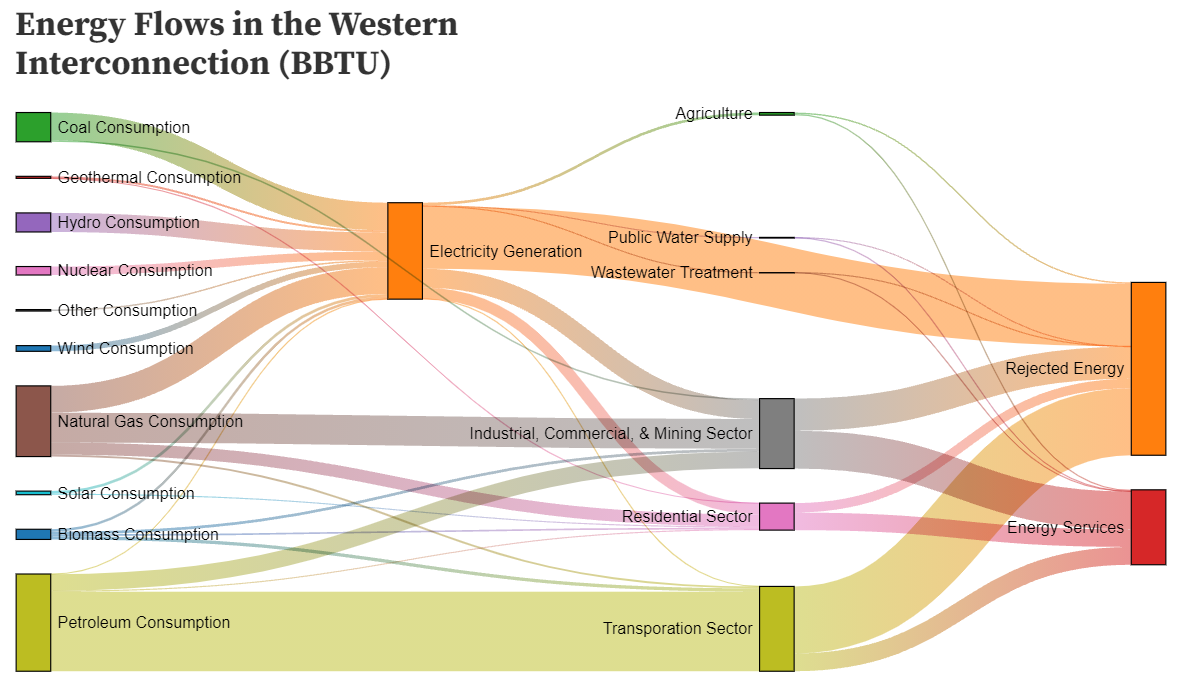

#### e-Sankey
e-sankey is a proprietary sankey software option for building sankey diagrams that can be directly linked to excel files of data that automatically update as values are changed. This software offers a high level of customizability over other options, unlimited data flows, and multiple units. Information on e-sankey can be found here: https://www.ifu.com/e-sankey/. An example of an e-sankey diagram including all variables in the dataset generated from this notebook for the western interconnection are displayed in the image below.

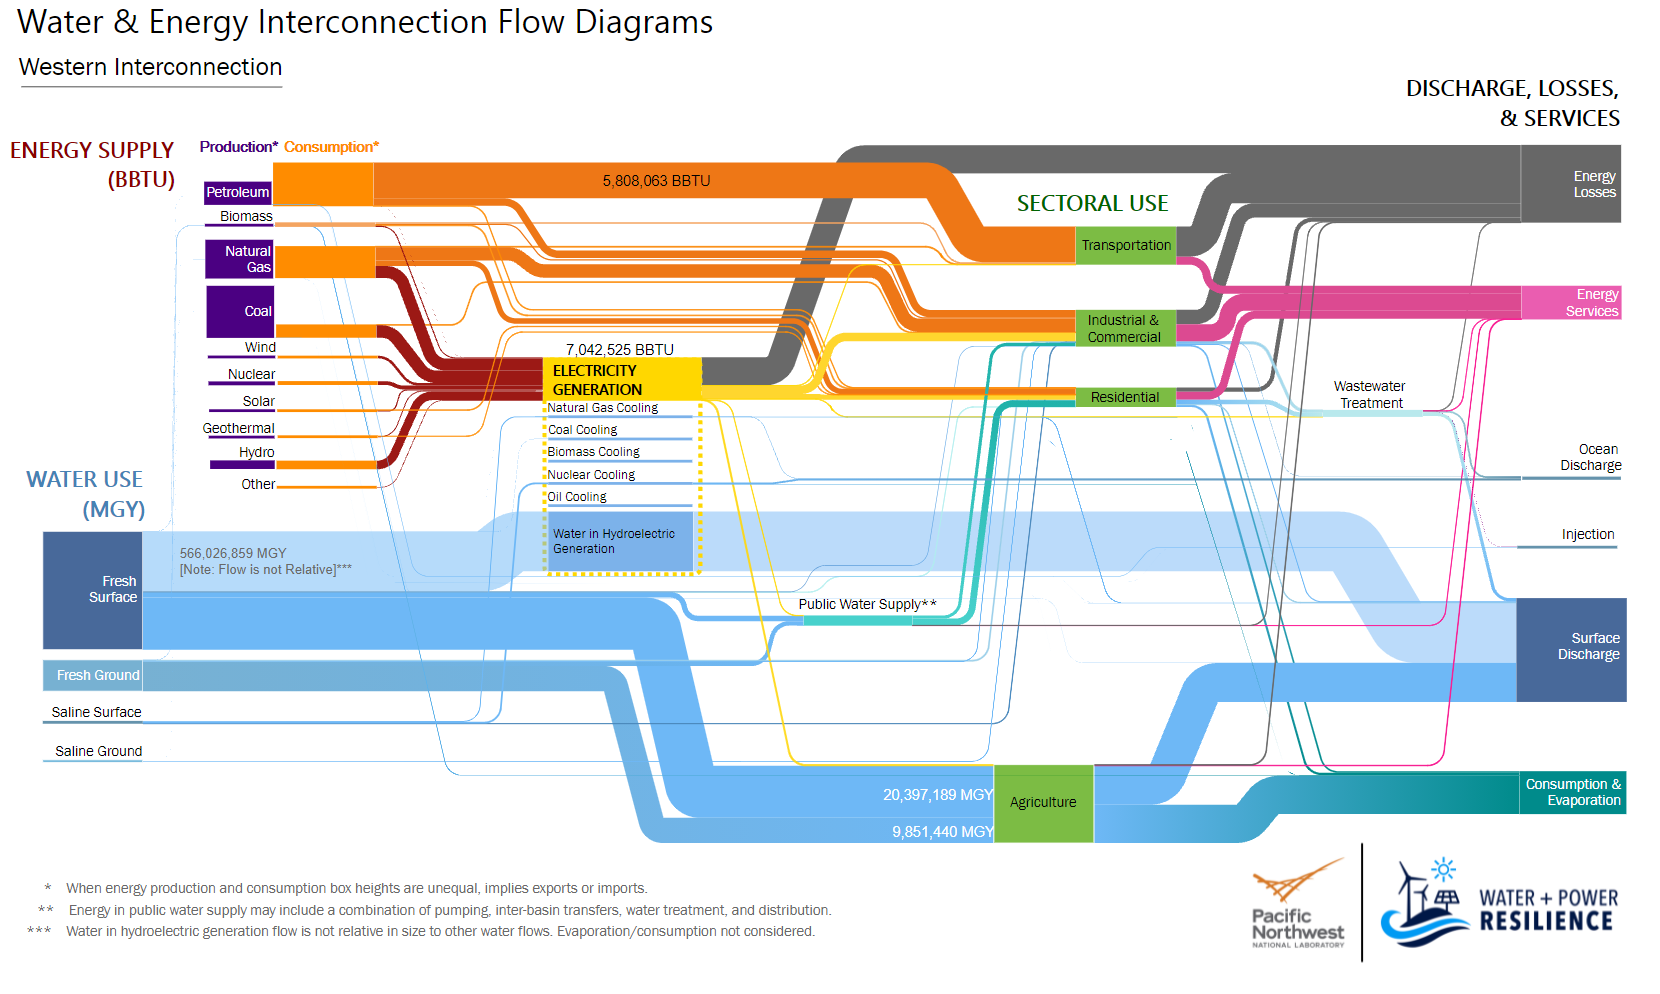

---

# References
1. Dieter, C. A., Maupin, M. A., Caldwell, R. R., Harris, M. A., Ivahnenko, T. I., Lovelace, J. K., Barber, N. L., & Linsey, K. S. (2018). Estimated use of water in the United States in 2015.
2. Electric Reliability Council of Texas. (2015). ERCOT Area by County. In ERCOT_County_Map_32515.pdf (Ed.). Texas: ERCOT.
3. U.S. Dept. of Energy (DOE). (2021). Learn More About Interconnections. U.S. DOE. Retrieved December 15 from https://www.energy.gov/oe/services/electricity-policy-coordination-and-implementation/transmission-planning/recovery-act-0
4. Solley, W. B., Pierce, R. R., & Perlman, H. A. (1998). Estimated use of water in the United States in 1995 [Report](1200). (Circular, Issue. U. S. G. S. U.S. Dept. of the Interior & S. Branch of Information. http://pubs.er.usgs.gov/publication/cir1200
5.  Greenberg, H. R., Simon, A. J., Singer, S. L., & Shuster, E. P. (2017). Development of Energy-Water Nexus State-level Hybrid Sankey Diagrams for 2010 (LLNL-TR-669059). https://flowcharts.llnl.gov/content/assets/docs/2010_United-States_EnergyWater.pdf
6. Harris, M.A., and Diehl, T.H., 2019, Withdrawal and consumption of water by thermoelectric power plants in the United States, 2015: U.S. Geological Survey Scientific Investigations Report 2019–5103, 15 p., https://doi.org/10.3133/sir20195103.
7. U.S. EPA. (2016). County Population. https://www.epa.gov/ozone-designations/ozone-designations-guidance-and-data 
8. U.S. Department of Commerce. (2021). QuickFacts: Kusilvak Census Area, Alaska; Oglala Lakota County, South Dakota. U.S., Department of Commerce. Retrieved August 15 from https://www.census.gov/quickfacts/fact/table/kusilvakcensusareaalaska,oglalalakotacountysouthdakota/HSD410219
9. U.S. Department of Commerce. (2020). Understanding the Population of the U.S. Virgin Islands. U.S. Department of Commerce,. Retrieved August 15 from https://www.census.gov/content/dam/Census/programs-surveys/sis/resources/2020/sis_2020map_usvi_k-12.pdf
10. U.S. EPA. (2016). Clean Watersheds Needs Survey 2012: Report to Congress (EPA-830-R-15005). https://www.epa.gov/sites/default/files/2015-12/documents/cwns_2012_report_to_congress-508-opt.pdf
11. U.S. EPA. (2016). Clean Watersheds Needs Survey – 2012 Data Dictionary. https://19january2017snapshot.epa.gov/sites/production/files/2016-01/documents/cwns-2012-data_dictionary2.pdf
12. U.S. Energy Information Administration (EIA). (2016). Form EIA-923 detailed data with previous form data (EIA-906/920). U.S. EIA. Retrieved January 15 from https://www.eia.gov/electricity/data/eia923/
13. Vilsack, T. (2014). 2013 Farm and Ranch Irrigation Survey Part 1 (AC-12-SS1). (2012 Census of Agriculture, Issue. https://www.nass.usda.gov/Publications/AgCensus/2012/Online_Resources/Farm_and_Ranch_Irrigation_Survey/fris13.pdf
14. Tidwell, V. C., Moreland, B., & Zemlick, K. (2014). Geographic Footprint of Electricity Use for Water Services in the Western U.S. Environmental Science & Technology, 48(15), 8897-8904. https://doi.org/10.1021/es5016845 
15. Lawrence Berkeley National Laboratory (LBNL). (2021). Well-pump energy calculation method. LBNL. Retrieved August 12 from http://hes-documentation.lbl.gov/calculation-methodology/calculation-of-energy-consumption/major-appliances/miscellaneous-equipment-energy-consumption/well-pump-energy-calculation-method
16. Texas Water Development Board. (2020). Interbasin Transfers Excluding the Rio Grande Basin. Texas Water Development Board. Retrieved September 10 from http://www.twdb.texas.gov/waterplanning/rwp/ipc/docs/resources/IBTs_06_09_2020.pdf
17. Pabi, S., Amarnath, A., Goldstein, R., & Reekie, L. (2013). Electricity Use and Management in the Municipal Water Supply and Wastewater Industries (3002001433). https://www.epri.com/research/products/000000003002001433
18. U.S. EIA. (2016). Annual Electric Power Industry Report, Form EIA-861 detailed data files. U.S. EIA. Retrieved July 10 from https://www.eia.gov/electricity/data/eia861/
19. EIA, U. S. (2016). State Energy Data System (SEDS): 1960-2019 (complete). U.S EIA. Retrieved July 17 from https://www.eia.gov/state/seds/seds-data-complete.php?sid=US
20. LLNL. (2017). Estimated U.S. Energy Consumption in 2015: 97.2 Quads (2017 Revision). Lawrence Livermore National Laboratory (LLNL). Retrieved September 10 from https://flowcharts.llnl.gov/content/assets/images/charts/Energy/Energy_2015_United-States.png
21. U.S. DOE. (2021). U.S. Corn Production and Portion Used for Fuel Ethanol. U.S., DOE. Retrieved September 10 from https://afdc.energy.gov/data/10339
22. Perdue, S. (2019). 2018 Irrigation and Water Management Survey (Special Studies, Issue. https://www.nass.usda.gov/Publications/AgCensus/2017/Online_Resources/Farm_and_Ranch_Irrigation_Survey/fris.pdf
23. USDA. (2015). National Agricultural Statistics Service. https://quickstats.nass.usda.gov/ 
24. USDA. (2020). County-level Oil and Gas Production in the U.S. USDA. Retrieved February 22 from https://www.ers.usda.gov/data-products/county-level-oil-and-gas-production-in-the-us.aspx
25. U.S. EIA. (2021). Crude Oil Production. https://www.eia.gov/dnav/pet/pet_crd_crpdn_adc_mbbl_a.htm 
26. EIA, U. S. (2021). Natural Gas Gross Withdrawals and Production. https://www.eia.gov/dnav/ng/ng_prod_sum_a_epg0_fgw_mmcf_a.htm 
27. U.S. EIA. (2021). How much shale (tight) oil is produced in the United States? U.S. EIA. Retrieved January 17 from https://www.eia.gov/tools/faqs/faq.php?id=847&t=6
28. Veil, J. (2020). U.S. Produced Water Volumes and Management Practices in 2017. http://www.veilenvironmental.com/publications/pw/pw_report_2017_final.pdf
29. U.S. EIA. (2021). Texas Field Production of Crude Oil. U.S. EIA. Retrieved February 22 from https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=MCRFPTX1&f=M
30. U.S. EIA. (2016). Detailed Building Characteristics from the 2018 CBECS. U.S. EIA. Retrieved Febuary 23 from https://www.eia.gov/coal/data.php
31. U.S. Department of Labor- Mine Safety and Health Administration. (2021). Mine Data Retrieval System. Mine Safety and Health Administration. Retrieved September 13 from https://www.msha.gov/mine-data-retrieval-system
32. U.S. EIA. (2019). More than half of the U.S. coal mines operating in 2008 have since closed. U.S. EIA. Retrieved September 10 from https://www.eia.gov/todayinenergy/detail.php?id=38172